# Relative Valuation Chatbot

Bloomberg x NYU Capstone Project<br>
Authors: Niko Liu(jl8831@nyu.edu), Yinyin Tong(yt2660@nyu.edu)

**This notebook is designed to assist investment banking analysts in identifying comparable companies for relative valuation. It does so by utilizing natural language processing techniques, particularly with the use of langchain custom agents. By collecting vast amounts of data from the 10-K reports of S&P 500 companies, we've established a comprehensive database to ensure precise results.**

<img src="https://media.istockphoto.com/id/1256321357/photo/initial-public-offering.jpg?s=612x612&w=0&k=20&c=bxwtdXck40DYabE4sbCTPuvolqEGs_05FMoSjDUh2Oo=" alt="Online Image" width="40%">


## Setup

### Install and Import Packages

In [ ]:
!pip -q install langchain huggingface_hub transformers sentence_transformers accelerate bitsandbytes openai tiktoken pinecone-client datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 95.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 11.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 80.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.1/179.1 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 100.2 MB/s eta 0:0

In [ ]:
# !pip -q install faiss-gpu
!pip -q install faiss-cpu
!pip -q install chromadb
!pip -q install plotly
!pip -q install annoy apache_beam
!pip -q install boto3 s3fs
!pip -q install gradio
!pip -q install pytesseract
!pip -q install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 79.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 402.8/402.8 kB 4.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 7.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.7 MB/s eta 0:00:00
     ━━━━━

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import plotly.express as px
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from langchain.llms import HuggingFacePipeline
from langchain import PromptTemplate, HuggingFaceHub, LLMChain
import torch
# from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline, AutoModelForSeq2SeqLM
from langchain.embeddings import OpenAIEmbeddings
import pandas as pd
import pinecone
from datasets import load_dataset
from langchain.vectorstores import FAISS
from sentence_transformers import SentenceTransformer
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.document_loaders.csv_loader import CSVLoader
from langchain.document_loaders import DataFrameLoader
import os
from langchain.vectorstores import Chroma
import boto3
from langchain.tools import BaseTool

from langchain.agents import Tool, AgentExecutor, LLMSingleActionAgent, AgentOutputParser, initialize_agent
from langchain.prompts import StringPromptTemplate
from langchain import SerpAPIWrapper, LLMChain
from langchain.llms import OpenAI
from langchain.schema import AgentAction, AgentFinish, OutputParserException
from typing import List, Union
import re
from annoy import AnnoyIndex
from langchain.agents import create_pandas_dataframe_agent
from langchain.chat_models import ChatOpenAI
from langchain.agents.agent_types import AgentType
from langchain.tools import StructuredTool
from langchain import PromptTemplate, OpenAI, LLMChain

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import gradio as gr
from langchain.chains.question_answering import load_qa_chain
import yfinance as yf
from pydantic import BaseModel, Field
from typing import Optional, Type
from langchain.tools import MoveFileTool, format_tool_to_openai_function
from langchain.prompts import MessagesPlaceholder
from langchain.memory import ConversationBufferMemory
import requests
import io
import warnings
warnings.filterwarnings("ignore")
import os
import math
import sys
from bs4 import BeautifulSoup
from PIL import Image
from pytesseract import pytesseract
import streamlit as st
import plotly.io as pio
from langchain.callbacks import StreamlitCallbackHandler
from langchain.output_parsers import CommaSeparatedListOutputParser
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib
import seaborn as sns

/usr/local/lib/python3.10/dist-packages/pinecone/index.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
!pip -q install sec-cik-mapper sec-api

In [ ]:
from sec_cik_mapper import StockMapper
from pathlib import Path
import pandas as pd
from langchain import OpenAI, PromptTemplate, LLMChain
from langchain.chat_models import ChatOpenAI
from langchain.text_splitter import CharacterTextSplitter
from langchain.chains.mapreduce import MapReduceChain
from langchain.chains.combine_documents.reduce import ReduceDocumentsChain
from langchain.chains.combine_documents.map_reduce import MapReduceDocumentsChain
from langchain.chains.combine_documents.stuff import StuffDocumentsChain
from langchain.prompts import PromptTemplate
from sec_api import FullTextSearchApi
from sec_api import ExtractorApi
from sec_api import QueryApi
import json
import re
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.chains.summarize import load_summarize_chain
import textwrap
import time
import asyncio
import random
import os

In [ ]:
pio.templates.default = "plotly"

In [ ]:
# !pip install protobuf==3.20.0

### Set API Keys

In [ ]:
from getpass import getpass

OPENAI_TOKEN = getpass()

··········


In [ ]:
from getpass import getpass
print('Please input your access key to S3')
s3_access_key = getpass()
print('Please input your secret access key to S3')
s3_secret_access_key = getpass()

Please input your access key to S3
··········
Please input your secret access key to S3
··········


In [ ]:
from getpass import getpass
print('Please input your access token to SEC API')
sec_api_key = getpass()

Please input your access token to SEC API
··········


In [ ]:
import os

#os.environ['OPENAI_TOKEN'] = ''
os.environ['OPENAI_TOKEN'] = OPENAI_TOKEN

os.environ['PINECONE_API_KEY'] = 'b391a384-c6b1-44f8-8410-671ebc8a77f9'
os.environ['PINECONE_ENVIRONMENT'] = 'us-west1-gcp-free'
# os.environ['PINECONE_ENVIRONMENT'] = 'asia-southeast1-gcp-free'
# PINECONE_API_KEY = os.environ.get('PINECONE_API_KEY')
# PINECONE_ENV = os.environ.get('PINECONE_ENVIRONMENT')

In [ ]:
pinecone.init(
   api_key=os.environ['PINECONE_API_KEY'],
   environment=os.environ['PINECONE_ENVIRONMENT']
)

### Connect to s3 data storage client

In [ ]:
s3client = boto3.resource(service_name = 's3',
                          region_name = 'us-west-1',
                        aws_access_key_id = s3_access_key,
                        aws_secret_access_key = s3_secret_access_key)

In [ ]:
for obj in s3client.Bucket('nyu-bbg-capstone').objects.all():
    print(obj)

s3.ObjectSummary(bucket_name='nyu-bbg-capstone', key='10-K_metadata.csv')
s3.ObjectSummary(bucket_name='nyu-bbg-capstone', key='RV_dataset.csv')
s3.ObjectSummary(bucket_name='nyu-bbg-capstone', key='Refinitiv_dataset.csv')
s3.ObjectSummary(bucket_name='nyu-bbg-capstone', key='business_summary.csv')
s3.ObjectSummary(bucket_name='nyu-bbg-capstone', key='company_tickers.json')
s3.ObjectSummary(bucket_name='nyu-bbg-capstone', key='constituents_csv.csv')
s3.ObjectSummary(bucket_name='nyu-bbg-capstone', key='metadata_10K_biz.csv')


## Data Acquisition and Preprocessing

#### S1 Scraping(Attempt)

In [ ]:
response = requests.get(
  url='https://proxy.scrapeops.io/v1/',
  params={
      'api_key': '8cfd16ce-e58a-4369-a5df-26554192dd5f',
      'url': 'https://www.sec.gov/Archives/edgar/data/1805833/000119312522104388/d272165ds1a.htm#rom272165_1',
  },
)
html_content=response.content
html = html_content.decode('utf-8')

In [ ]:
re_text = re.compile(r'(summary highlights.*?THE Offering </B></P>)', re.DOTALL | re.IGNORECASE)
data_raw = re_text.findall(html)

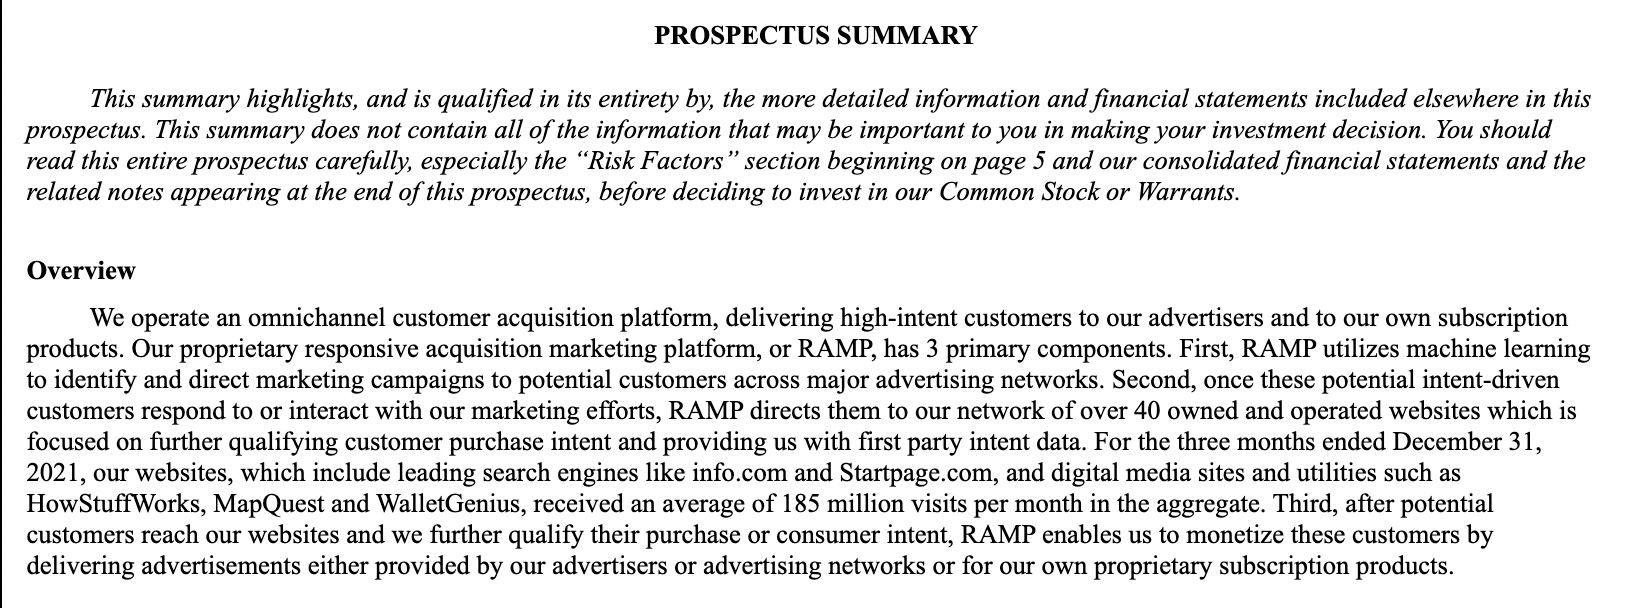

In [ ]:
# Import index information
s3obj = s3client.Bucket('nyu-bbg-capstone').Object('Refinitiv_dataset.csv').get()
sp500_index = pd.read_csv(s3obj['Body'])

In [ ]:
mapper = StockMapper()
tik2cik = pd.DataFrame(list(mapper.ticker_to_cik.items()), columns=['ticker', 'cik'])
tik2cik['sp500'] = tik2cik['ticker'].isin(list(sp500_index['Ticker Symbol'].values))
sp500_map = tik2cik[tik2cik['sp500']].drop('sp500', axis=1).reset_index(drop=True)
ticker_string = ",".join(tuple(sp500_index['Ticker Symbol'].values))

In [ ]:
sp500_map.head(3)

,ticker,cik
0,ABT,0000001800
1,AMD,0000002488
2,APD,0000002969


#### Fetch S&P500 filing metadata from SEC

In [ ]:
fullTextSearchApi = FullTextSearchApi(api_key=sec_api_key)
queryApi = QueryApi(api_key=sec_api_key)

In [ ]:
all_metadata = []
batch_size = 200
total_records = 600

In [ ]:
def fetch_data(from_value):
    search_query = {
        "query": {
            "query_string": {
                "query": f"formType:\"10-K\" AND ticker:({ticker_string}) AND filedAt:[2022-01-01T00:00:00.000 TO 2022-12-31T00:00:00.000]"
            }
        },
        "from": from_value,
        "size": batch_size,
        "sort": [{"filedAt": {"order": "desc"}}]
    }

    response = queryApi.get_filings(search_query)
    return response['filings']

In [ ]:
for from_value in range(0, total_records, batch_size):
    filings_data = fetch_data(from_value)
    if not filings_data:
        break
    all_metadata.extend(filings_data)

In [ ]:
metadata = pd.DataFrame.from_records(all_metadata)
metadata.to_csv('10-K_metadata.csv', index=True)
metadata.head(3)

,id,accessionNo,cik,ticker,companyName,companyNameLong,formType,description,filedAt,linkToTxt,linkToHtml,linkToXbrl,linkToFilingDetails,entities,documentFormatFiles,dataFiles,seriesAndClassesContractsInformation,periodOfReport,effectivenessDate
0,876ec1803fd5ef9b783ac972a5cda137,0001090872-22-000026,1090872,A,"AGILENT TECHNOLOGIES, INC.","AGILENT TECHNOLOGIES, INC. (Filer)",10-K,Form 10-K - Annual report [Section 13 and 15(d...,2022-12-20T18:42:30-05:00,https://www.sec.gov/Archives/edgar/data/109087...,https://www.sec.gov/Archives/edgar/data/109087...,,https://www.sec.gov/Archives/edgar/data/109087...,"[{'companyName': 'AGILENT TECHNOLOGIES, INC. (...","[{'sequence': '1', 'description': '10-K', 'doc...","[{'sequence': '8', 'description': 'XBRL TAXONO...",[],2022-10-31,NaN
1,2fbd04123117c44e96d2170a59460e89,0000072331-22-000185,72331,NDSN,NORDSON CORP,NORDSON CORP (Filer),10-K,Form 10-K - Annual report [Section 13 and 15(d...,2022-12-19T08:12:18-05:00,https://www.sec.gov/Archives/edgar/data/72331/...,https://www.sec.gov/Archives/edgar/data/72331/...,,https://www.sec.gov/Archives/edgar/data/72331/...,"[{'companyName': 'NORDSON CORP (Filer)', 'cik'...","[{'sequence': '1', 'description': '10-K', 'doc...","[{'sequence': '8', 'description': 'XBRL TAXONO...",[],2022-10-31,NaN
2,658c0dd34a8ae4a17cead6d39ce88df2,0000006951-22-000043,6951,AMAT,APPLIED MATERIALS INC /DE,APPLIED MATERIALS INC /DE (Filer),10-K,Form 10-K - Annual report [Section 13 and 15(d...,2022-12-16T16:50:05-05:00,https://www.sec.gov/Archives/edgar/data/6951/0...,https://www.sec.gov/Archives/edgar/data/6951/0...,,https://www.sec.gov/Archives/edgar/data/6951/0...,[{'companyName': 'APPLIED MATERIALS INC /DE (F...,"[{'sequence': '1', 'description': '10-K', 'doc...","[{'sequence': '10', 'description': 'XBRL TAXON...",[],2022-10-30,NaN


In [ ]:
extractorApi = ExtractorApi(sec_api_key)

In [ ]:
metadata_10K = pd.read_csv('10-K_metadata.csv')

In [ ]:
# Take long time to run, save the result locally to faster access
for index, row in metadata_10K.iloc[10:11].iterrows():
    url_10k = row['linkToHtml']
    item_1 = extractorApi.get_section(url_10k, "1", "text")
    text = re.sub('&#\d+;', ' ', item_1)
    text = re.sub('##\w+', ' ', text)
    text = re.sub('\s+', ' ', text).strip()
    metadata_10K.loc[index, '10K_item1'] = text
    time.sleep(0.11)

### Using Map-reduce techniques to summarize the 10-K business section

As we retrieve the 10-K annual reports from S&P 500 companies, it becomes evident that certain sections are quite extensive, potentially surpassing the token limit of the OpenAI model. To address this challenge, we have implemented map-reduce techniques in an attempt to condense and streamline these lengthy sections effectively.

<img src="https://miro.medium.com/v2/resize:fit:828/format:webp/1*GqeQ5FnJ0q-s1P6CmppR5A.png" alt="Online Image" width="40%">

source: https://blog.gopenai.com/backoff-retry-mapreduce-for-openai-net-dev-in-llm-era-e25b22dc7a59

In [ ]:
llm = ChatOpenAI(model_name='gpt-3.5-turbo-16k',temperature=0,request_timeout=60, max_retries=3, openai_api_key=os.environ['OPENAI_TOKEN'])

In [ ]:
s3obj = s3client.Bucket('nyu-bbg-capstone').Object('metadata_10K_biz.csv').get()
metadata_10K_biz = pd.read_csv(s3obj['Body'])

In [ ]:
metadata_10K_biz['token_count'] = metadata_10K_biz['10K_item1'].apply(llm.get_num_tokens)

In [ ]:
mean_tokens = metadata_10K_biz['token_count'].mean()
percentile_75 = metadata_10K_biz['token_count'].quantile(0.75)
max_tokens = metadata_10K_biz['token_count'].max()

In [ ]:
sns.set(style="whitegrid")

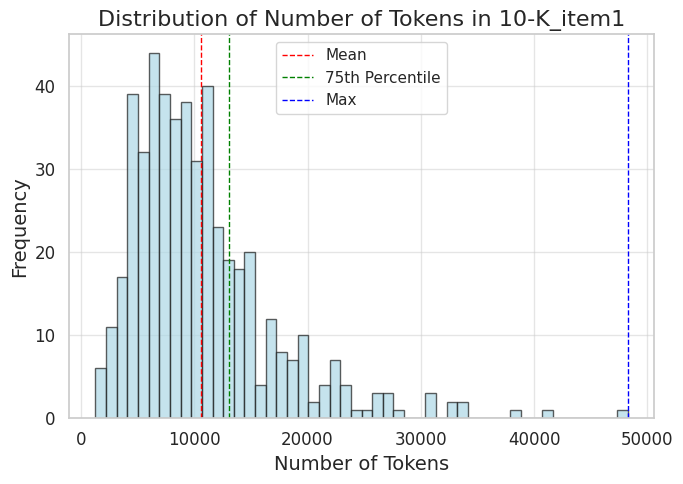

In [ ]:
# Create the histogram plot
plt.figure(figsize=(7, 5))
plt.hist(metadata_10K_biz['token_count'], bins=50, edgecolor='k', alpha=0.7, color='lightblue')

# Add vertical lines for summary statistics
plt.axvline(mean_tokens, color='red', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(percentile_75, color='green', linestyle='dashed', linewidth=1, label='75th Percentile')
plt.axvline(max_tokens, color='blue', linestyle='dashed', linewidth=1, label='Max')

# Add legend
plt.legend()

# Set plot title and labels
plt.title('Distribution of Number of Tokens in 10-K_item1', fontsize=16)
plt.xlabel('Number of Tokens', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Adjust tick label size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add grid lines
plt.grid(True, alpha=0.5)

# Show the plot
plt.tight_layout()
plt.show()

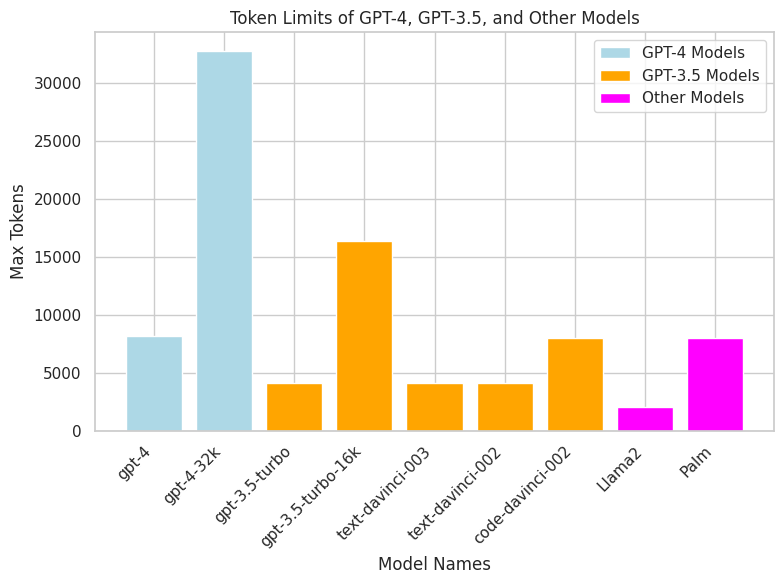

In [ ]:
import matplotlib.pyplot as plt

# Data for GPT-4 models
gpt4_models = [
    "gpt-4", "gpt-4-32k",
]
gpt4_tokens = [8192, 32768]

# Data for GPT-3.5 models
gpt3_5_models = [
    "gpt-3.5-turbo", "gpt-3.5-turbo-16k", "text-davinci-003", "text-davinci-002", "code-davinci-002"
]
gpt3_5_tokens = [4096, 16384, 4097, 4097, 8001]

# Data for other models
other_models = ["Llama2", "Palm"]
other_tokens = [2048, 8000]

# Plotting
plt.figure(figsize=(8, 6))

# GPT-4 bars
plt.bar(gpt4_models, gpt4_tokens, color='lightblue', label='GPT-4 Models')

# GPT-3.5 bars
plt.bar(gpt3_5_models, gpt3_5_tokens, color='orange', label='GPT-3.5 Models')

# New models bars
plt.bar(other_models, other_tokens, color='magenta', label='Other Models')

# Title and labels
plt.title('Token Limits of GPT-4, GPT-3.5, and Other Models')
plt.xlabel('Model Names')
plt.ylabel('Max Tokens')
plt.xticks(rotation=45, ha='right')
plt.legend()

# Display the graph
plt.tight_layout()
plt.show()

In [ ]:
llm = ChatOpenAI(model_name='gpt-3.5-turbo-16k',temperature=0,request_timeout=60, max_retries=3, openai_api_key=os.environ['OPENAI_TOKEN'])

<img src="https://miro.medium.com/v2/resize:fit:786/format:webp/1*TzeehhqUgNqLmomT424ggg.png" alt="Online Image" width="50%">

In [ ]:
map_template = """Write a business summary for the following company description:


{texts}


Speak like the financial analyst. MEDIUM LENGTH SUMMARY:"""

map_prompt = PromptTemplate(input_variables=["texts"], template=map_template)
map_chain = LLMChain(llm=llm, prompt=map_prompt)

<img src="https://miro.medium.com/v2/resize:fit:828/format:webp/1*HbQyXjEG9CQJLKLZMxSZ_g.png" alt="Online Image" width="50%">

In [ ]:
reduce_template = """The following is set of summaries:


{texts_summaries}


Speak like the financial analyst, Take these and distill it into a final, medium length summary:"""

reduce_prompt = PromptTemplate(input_variables=["texts_summaries"], template=reduce_template)
reduce_chain = LLMChain(llm=llm, prompt=reduce_prompt)

# Takes a list of documents, combines them into a single string, and passes this to an LLMChain
combine_documents_chain = StuffDocumentsChain(
    llm_chain=reduce_chain, document_variable_name="texts_summaries"
)

# Combines and iteravely reduces the mapped documents
reduce_documents_chain = ReduceDocumentsChain(
    # This is final chain that is called.
    combine_documents_chain=combine_documents_chain,
    collapse_documents_chain=combine_documents_chain,
    token_max=30000,
)

In [ ]:
# Combining documents by mapping a chain over them, then combining results
map_reduce_chain = MapReduceDocumentsChain(
    # Map chain
    llm_chain=map_chain,
    # Reduce chain
    reduce_documents_chain=reduce_documents_chain,
    document_variable_name="texts",
    return_intermediate_steps=False,
)

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 70000,
    chunk_overlap  = 1000,
    length_function = len
)

In [ ]:
async def llm_get_summary_map_reduce_async(text_,chain_):
    texts_ = text_splitter.create_documents([text_])
    output_summary = await chain_.arun(texts_)
    return output_summary

async def process_row(row):
    print(row['ticker'])
    biz_des = row['10K_item1']
    biz_summary = await llm_get_summary_map_reduce(biz_des, map_reduce_chain)

    file_name = os.path.join('data', f"{row['ticker']}.txt")
    with open(file_name, 'w') as file:
        file.write(biz_summary)
    return biz_summary

async def generate_concurrently():
    tasks = [process_row(row) for _, row in metadata_10K_biz.iloc[:2].iterrows()]
    await asyncio.gather(*tasks)

In [ ]:
# await generate_concurrently()

In [ ]:
def llm_get_summary_map_reduce(text_,chain_):
    texts_ = text_splitter.create_documents([text_])
    output_summary = chain_.run(texts_)
    return output_summary

Run with caution. This section takes long time to run >= 3hrs and consume large amount of tokens.


In [ ]:
# Takes long time to run >= 3hrs and consume large amount of tokens. Run with caution.
for index, row in metadata_10K_biz.iloc[0:500].iterrows():
    break
    print(row['ticker'])
    biz_des = row['10K_item1']
    biz_summary = llm_get_summary_map_reduce(biz_des, map_reduce_chain)
    file_name = os.path.join('data', f"{row['ticker']}.txt")
    with open(file_name, 'w') as file:
        file.write(biz_summary)

In [ ]:
# data_list = []
# dir_path = 'data'
# files = [f for f in os.listdir(dir_path) if f.endswith('.txt')]
# for file in files:
#     ticker = os.path.splitext(file)[0]
#     with open(os.path.join(dir_path, file), 'r') as f:
#         biz_summary = f.read()
#     data_list.append([ticker, biz_summary])

In [ ]:
# biz_df = pd.DataFrame(data_list, columns=['ID', 'biz_summary'])
# biz_df.rename(columns={'ID':'Ticker Symbol'}, inplace=True)

In [ ]:
# merged_df = pd.merge(biz_df, sp500_index, on='Ticker Symbol', how='inner')
# merged_df = merged_df.iloc[:,:13].drop('Business Description',axis=1)
# merged_df.to_csv('RV_dataset.csv', index=False)

## Load Dataset

### Business summary data

In [ ]:
s3client = boto3.resource(service_name = 's3',
                          region_name = 'us-west-1',
                        aws_access_key_id = s3_access_key,
                        aws_secret_access_key = s3_secret_access_key)

In [ ]:
for obj in s3client.Bucket('nyu-bbg-capstone').objects.all():
    print(obj)

s3.ObjectSummary(bucket_name='nyu-bbg-capstone', key='10-K_metadata.csv')
s3.ObjectSummary(bucket_name='nyu-bbg-capstone', key='RV_dataset.csv')
s3.ObjectSummary(bucket_name='nyu-bbg-capstone', key='Refinitiv_dataset.csv')
s3.ObjectSummary(bucket_name='nyu-bbg-capstone', key='business_summary.csv')
s3.ObjectSummary(bucket_name='nyu-bbg-capstone', key='company_tickers.json')
s3.ObjectSummary(bucket_name='nyu-bbg-capstone', key='constituents_csv.csv')
s3.ObjectSummary(bucket_name='nyu-bbg-capstone', key='metadata_10K_biz.csv')


In [ ]:
s3obj = s3client.Bucket('nyu-bbg-capstone').Object('RV_dataset.csv').get()
data = pd.read_csv(s3obj['Body'])
data.head(3)

,Ticker Symbol,biz_summary,Identifier,Company Name,GICS Sector Name,GICS Industry Group Name,GICS Industry Name,GICS Sub-Industry Name,GICS Sector Code,GICS Industry Group Code,GICS Industry Code,GICS Sub-Industry Code
0,A,Agilent Technologies Inc. is a global leader i...,A.N,Agilent Technologies Inc,Health Care,"Pharmaceuticals, Biotechnology & Life Sciences",Life Sciences Tools & Services,Life Sciences Tools & Services,35,"3,520","352,030","35,203,010"
1,AAL,American Airlines Group Inc. (AAG) is a major ...,AAL.OQ,American Airlines Group Inc,Industrials,Transportation,Passenger Airlines,Passenger Airlines,20,"2,030","203,020","20,302,010"
2,AAP,"Advance Auto Parts, Inc. is a leading automoti...",AAP.N,Advance Auto Parts Inc,Consumer Discretionary,Consumer Discretionary Distribution & Retail,Specialty Retail,Automotive Retail,25,"2,550","255,040","25,504,050"


In [ ]:
# Drop duplicated companies (A/C class share)
data = data.drop_duplicates(subset='Identifier',keep='first').reset_index(drop=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 488 entries, 0 to 487
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Ticker Symbol             488 non-null    object
 1   biz_summary               488 non-null    object
 2   Identifier                488 non-null    object
 3   Company Name              488 non-null    object
 4   GICS Sector Name          488 non-null    object
 5   GICS Industry Group Name  488 non-null    object
 6   GICS Industry Name        488 non-null    object
 7   GICS Sub-Industry Name    488 non-null    object
 8   GICS Sector Code          488 non-null    int64 
 9   GICS Industry Group Code  488 non-null    object
 10  GICS Industry Code        488 non-null    object
 11  GICS Sub-Industry Code    488 non-null    object
dtypes: int64(1), object(11)
memory usage: 45.9+ KB


In [ ]:
company_index_list=data.index.tolist()
industry_list = data['GICS Sector Name'].tolist()
company_list = data['Company Name'].tolist()

Dataframe with all the companies in Utilities Industry

In [ ]:
Utilities_companies = data.loc[data['GICS Sector Name'] == 'Utilities']
utilities_company_index_list=Utilities_companies.index.tolist()
utilities_industry_list = Utilities_companies['GICS Sector Name'].tolist()
Utilities_companies.info()
utilities_company_list=Utilities_companies['Company Name'].tolist()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29 entries, 14 to 479
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Ticker Symbol             29 non-null     object
 1   biz_summary               29 non-null     object
 2   Identifier                29 non-null     object
 3   Company Name              29 non-null     object
 4   GICS Sector Name          29 non-null     object
 5   GICS Industry Group Name  29 non-null     object
 6   GICS Industry Name        29 non-null     object
 7   GICS Sub-Industry Name    29 non-null     object
 8   GICS Sector Code          29 non-null     int64 
 9   GICS Industry Group Code  29 non-null     object
 10  GICS Industry Code        29 non-null     object
 11  GICS Sub-Industry Code    29 non-null     object
dtypes: int64(1), object(11)
memory usage: 2.9+ KB


Ten companies with 5 tech companies and 5 energy companies

In [ ]:
biz_sum_obj = s3client.Bucket('nyu-bbg-capstone').Object('business_summary.csv').get()
df = pd.read_csv(biz_sum_obj['Body'], index_col=0, encoding='latin-1')
df.head()

,businessSummary,RIC,Industry,incorporatedCountry,incorporatedDate,incorporatedCountryCode,timestamp
ID,,,,,,,
0,"Apple Inc. (Apple) designs, manufactures and m...",AAPL.O,Technology,United States,3-Jan-77,US,2023-07-01T03:14:25.600Z
1,"Tesla, Inc. designs, develops, manufactures, s...",TSLA.O,Technology,United States,1-Jul-03,US,2023-07-01T03:25:52.529Z
2,Microsoft Corporation is a technology company....,MSFT.O,Technology,United States,22-Sep-93,US,2023-07-01T03:26:22.029Z
3,"Netflix, Inc. is an entertainment services com...",NFTX.O,Technology,United States,29-Aug-97,US,2023-07-01T03:26:42.631Z
4,Alphabet Inc. is a holding company. The Compan...,GOOG.O,Technology,United States,23-Jul-15,US,2023-07-01T03:27:00.944Z


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# file_path = '/content/drive/My Drive/NYU/Bloomberg/Data/business_summary.csv'
# df = pd.read_csv(file_path, index_col=0,  encoding='latin-1')
# df.head()

In [ ]:
sample_company_list=df['RIC'].tolist()[:25]
sample_industry_list = df['Industry'].tolist()[:25]

## Create Embedding

### HuggingFace Embedding

In [ ]:
from langchain.embeddings import HuggingFaceEmbeddings

model_name = "sentence-transformers/all-mpnet-base-v2"
model_kwargs = {'device': 'cuda'}
encode_kwargs = {'normalize_embeddings': False}

hf_embeddings = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

In [ ]:
b500_result = hf_embeddings.embed_documents(data['biz_summary'].tolist())
sample_result = hf_embeddings.embed_documents(df['businessSummary'].tolist())

In [ ]:
len(b500_result), len(b500_result[0]), len(sample_result), len(sample_result[0])

(488, 768, 10, 768)

In [ ]:
utilities_result = hf_embeddings.embed_documents(Utilities_companies['biz_summary'].tolist())
len(utilities_result), len(utilities_result[0])

(29, 768)

### OpenAI Embedding

In [ ]:
from langchain.embeddings import OpenAIEmbeddings

openai_embeddings_model = OpenAIEmbeddings(openai_api_key=os.environ['OPENAI_TOKEN'])

In [ ]:
openai_embeddings = openai_embeddings_model.embed_documents(data['biz_summary'].tolist())
len(openai_embeddings), len(openai_embeddings[0])

(488, 1536)

### Sentence Transformer

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device != 'cuda':
    print(f"You are using {device}. This is much slower than using "
          "a CUDA-enabled GPU. If on Colab you can change this by "
          "clicking Runtime > Change runtime type > GPU.")

st_model = SentenceTransformer('all-mpnet-base-v2', device=device)
st_model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

## Vector Similarity

### Semantic Search Euclidean/Cosine Using Pinecone

In [ ]:
index_name = 'semantic-search-cosine'

if index_name not in pinecone.list_indexes():
   pinecone.create_index(
       name=index_name,
       dimension=st_model.get_sentence_embedding_dimension(),
       metric='cosine'
    )

# connect to the index
index_cosine = pinecone.Index(index_name)

In [ ]:
from tqdm.auto import tqdm

batch_size = 64

input_data = data['biz_summary'].tolist()

for i in tqdm(range(0, len(input_data), batch_size)):
    # find end of batch
    i_end = min(i+batch_size, len(input_data))
    # create IDs batch
    ids = [str(x) for x in range(i, i_end)]
    # create metadata batch
    metadatas = [{'text': text} for text in input_data[i:i_end]]
    # create embeddings and convert them to list format
    embeddings_st = [embedding.tolist() for embedding in st_model.encode(input_data[i:i_end])]

    # create records list for upsert. This might need restructuring based on Pinecone's expected input format.
    # Assuming Pinecone expects a list of tuples where each tuple has format (id, vector, metadata)
    records = list(zip(ids, embeddings_st, metadatas))

    # upsert to Pinecone
    index_cosine.upsert(vectors=records)

# check number of records in the index
index_cosine.describe_index_stats()

  0%|          | 0/8 [00:00<?, ?it/s]

{'dimension': 768,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 488}},
 'total_vector_count': 488}

In [ ]:
query_tech = "Amazon.com, Inc. provides a range of products and services to customers. The products offered through its stores include merchandise and content that it purchased for resale and products offered by third-party sellers. It manufactures and sells electronic devices, including Kindle, Fire tablet, Fire TV, Echo, and Ring, and it develops and produces media content. It also offers subscription services such as Amazon Prime, a membership program. Its segments include North America, International and Amazon Web Services (AWS). The AWS segment consists of global sales of compute, storage, database, and other services for start-ups, enterprises, government agencies, and academic institutions. It provides advertising services to sellers, vendors, publishers, authors, and others, through programs, such as sponsored advertisements, display, and video advertising. Customers access its offerings through websites, mobile applications, Alexa, devices, streaming, and physically visiting its stores."

query_vec_tech = st_model.encode(query_tech).tolist()

query_result_tech = index_cosine.query(query_vec_tech, top_k=10, include_metadata=True)

In [ ]:
for result in query_result_tech['matches']:
    print(f"{round(result['score'], 2)}: {result['metadata']['text'][:50]}")

0.78: Amazon.com, Inc. is a customer-centric company ope
0.57: eBay Inc. is a global commerce leader operating Ma
0.51: Best Buy Co., Inc. is a prominent technology retai
0.5: Walmart Inc. is a global retail giant that operate
0.49: Apple Inc. is a renowned technology company that d
0.48: AT&T Inc. is a global telecommunications, media, a
0.48: Netflix is a global entertainment company that off
0.48: Comcast Corporation is a global media and technolo
0.47: Salesforce is a global leader in customer relation
0.47: Etsy Inc. is a global online marketplace that conn


In [ ]:
query_gas = "Petroleo Brasileiro S.A.-Petrobras specializes in the oil, natural gas and energy industry. The Company is engaged in prospecting, drilling, refining, processing, trading and transporting crude oil from producing onshore and offshore oil fields and from shale or other rocks. Its segments include Exploration and Production, which covers the activities of exploration, development and production of crude oil, natural gas liquid and natural gas; Refining, Transportation and Marketing, which covers the refining, logistics, transport and trading of crude oil and oil products activities, exporting of ethanol, and extraction and processing of shale; Gas and Power, which is engaged in transportation and trading of natural gas produced in Brazil and imported natural gas; Biofuels, which covers the activities of production of biodiesel and its co-products, and ethanol-related activities; Distribution, which includes the activities of its subsidiary Petrobras Distribuidora S.A., and Corporate."

query_vec_gas = st_model.encode(query_gas).tolist()

query_result_gas = index_cosine.query(query_vec_gas, top_k=10, include_metadata=True)

In [ ]:
for result in query_result_gas['matches']:
    print(f"{round(result['score'], 2)}: {result['metadata']['text'][:100]}")

0.6: Valero Energy Corporation is a multinational Fortune 500 company based in San Antonio, Texas. They a
0.55: Hess Corporation is a global exploration and production company involved in the exploration, develop
0.52: Marathon Oil Corporation is an independent exploration and production company primarily operating in
0.51: Coterra Energy Inc. is an independent oil and gas company operating in the continental U.S. with a f
0.51: The company is a leading energy infrastructure firm in North America, with an extensive network of p
0.51: Chevron Corporation is a global energy company that manages investments in integrated energy and che
0.5: Phillips 66 is a publicly traded company that operates in four segments: Midstream, Chemicals, Refin
0.5: Occidental Petroleum Corporation is a Delaware-based company operating in the oil and gas, chemical,
0.48: Exxon Mobil Corporation is a global energy company that operates in the exploration, production, and
0.48: Targa Resources Corp. is a promine

In [ ]:
query_rand = "The Procter & Gamble Company is focused on providing branded consumer packaged goods to the consumers across the world. The Company operates through five segments: Beauty; Grooming; Health Care; Fabric & Home Care, and Baby, Feminine & Family Care. The Company sells its products through approximately 180 countries and territories primarily through mass merchandisers, grocery stores, membership club stores, drug stores, department stores, distributors, wholesalers, baby stores, specialty beauty stores, e-commerce, high-frequency stores, pharmacies, electronics stores and professional channels. It offers products under the brands, such as Head & Shoulders, Herbal Essences, Pantene, Rejoice, Olay, Old Spice, Safeguard, Secret, SK-II, Braun, Gillette, Venus, Crest, Oral-B, Metamucil, Neurobion, Pepto-Bismol, Vicks, Ariel, Downy, Gain, Tide, Cascade, Dawn, Fairy, Febreze, Mr. Clean, Swiffer, Luvs, Pampers, Always, Always Discreet, Tampax, Bounty, Charmin and Puffs."

query_vec_rand = st_model.encode(query_rand).tolist()

query_result_rand = index_cosine.query(query_vec_rand, top_k=10, include_metadata=True)

In [ ]:
for result in query_result_rand['matches']:
    print(f"{round(result['score'], 2)}: {result['metadata']['text'][:100]}")

0.68: The Procter & Gamble Company (P&G) is a global consumer goods company that has established a strong 
0.58: The company is a leading manufacturer of food, beverage, health biosciences, scent, and pharma solut
0.57: Bath & Body Works is a leading specialty retailer in the home fragrance, body care products, and soa
0.55: The Estée Lauder Companies Inc. is a global leader in the beauty industry, known for its high-qualit
0.54: Colgate-Palmolive Company is a global leader in the Oral, Personal and Home Care market segments, as
0.54: Church & Dwight Co., Inc. is a well-established consumer household and personal care products compan
0.51: Kimberly-Clark Corporation is a global company that specializes in personal care, consumer tissue, a
0.5: Johnson & Johnson is a global healthcare company operating in three business segments: Consumer Heal
0.49: Newell Brands is a global consumer goods company that is focused on building a next-generation consu
0.49: Clorox Company, a leading multin

In [ ]:
query_rand_2 = "Snowflake Inc. is a cloud computing–based data cloud company based in Bozeman, Montana. It was founded in July 2012 and was publicly launched in October 2014 after two years in stealth mode. The firm offers a cloud-based data storage and analytics service, generally termed data-as-a-service"

query_vec_rand_2 = st_model.encode(query_rand_2).tolist()

query_result_rand_2 = index_cosine.query(query_vec_rand_2, top_k=10, include_metadata=True)

In [ ]:
for result in query_result_rand_2['matches']:
    print(f"{round(result['score'], 2)}: {result['metadata']['text'][:100]}")

0.4: NetApp, Inc. is a global software company that specializes in cloud-based data management solutions.
0.37: F5 is a leading multi-cloud application services and security provider that partners with large orga
0.33: Iron Mountain Incorporated is a leading global company that specializes in providing information man
0.31: ICE is a leading provider of market infrastructure, data services, and technology solutions in the f
0.31: FIS is a global technology solutions provider for merchants, banks, and capital markets firms. With 
0.27: Palo Alto Networks is a global cybersecurity provider that offers comprehensive platforms and servic
0.27: Tyler Technologies, Inc. is a leading provider of integrated information management solutions and se
0.27: Salesforce is a global leader in customer relationship management (CRM) technology, offering a platf
0.27: Netflix is a global entertainment company that offers streaming TV series, films, documentaries, and
0.27: Match Group, Inc. is a global pr

###Cosine Similarity
It is the most widely used method to compare two vectors. It is a dot product between two vectors.

<img src="https://miro.medium.com/v2/resize:fit:828/format:webp/1*Jnw2xFl2Kbf-7N793fSkBg.jpeg" alt="Online Image" width="40%">

In [ ]:
def get_cosine_similarity(feature_vec_1, feature_vec_2):
    return cosine_similarity(feature_vec_1.reshape(1, -1), feature_vec_2.reshape(1, -1))[0][0]

In [ ]:
def get_cosine_similarity_2(feature_vec_1, feature_vec_2):
    return cosine_similarity(feature_vec_1.reshape(1, -1), feature_vec_2)[0][0]

In [ ]:
#get the cosine similarity between the sample company description vectors"
sample_similarities = []
sample_similarity_matrix = np.zeros((len(sample_result), len(sample_result)))
for i in range(len(sample_result)):
    for j in range(i + 1, len(sample_result)):
        sample_similarity = get_cosine_similarity(np.array(sample_result[i]), np.array(sample_result[j]))
        sample_similarities.append((i, j, sample_similarity))
        sample_similarity_matrix[i, j] = sample_similarity
        sample_similarity_matrix[j, i] = sample_similarity

sample_similarities.sort(key=lambda x: x[2], reverse=True)

# Print top 10 similarities with indices
print("Top 10 Similarities:")
for i in range(10):
    index_1, index_2, similarity = sample_similarities[i]
    print(f"Similarity: {similarity:.4f} | {sample_company_list[index_1]} and {sample_company_list[index_2]}")

Top 10 Similarities:
Similarity: 0.7584 | XOM.N and CVX.N
Similarity: 0.7124 | XOM.N and SHEL.L
Similarity: 0.6885 | CVX.N and SHEL.L
Similarity: 0.6774 | XOM.N and BP.L
Similarity: 0.6684 | CVX.N and BP.L
Similarity: 0.6636 | SHEL.L and BP.L
Similarity: 0.6549 | BP.L and TTE.N
Similarity: 0.6349 | XOM.N and TTE.N
Similarity: 0.6320 | SHEL.L and TTE.N
Similarity: 0.5853 | CVX.N and TTE.N


*Observation: Top 10 similarities are all energy companies*

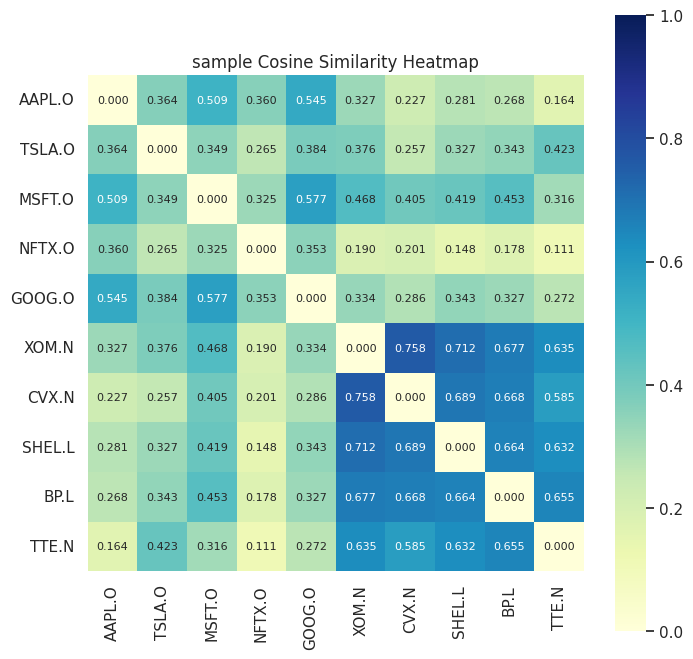

In [ ]:
#get heatmap
plt.figure(figsize=(8, 8))  # Adjust the figure size as needed
sns.heatmap(sample_similarity_matrix, cmap="YlGnBu", annot=True,
                  square=True,
                  fmt='.3f',
                  annot_kws={'size': 8},
                  yticklabels=sample_company_list,
                  xticklabels=sample_company_list,
                  vmin=0, vmax=1)
plt.title("sample Cosine Similarity Heatmap")
sns.set(font_scale=1)
plt.show()

Observation: The top left square and the bottom right square exhibit darker colors, indicating a stronger correlation. Additionally, the bottom right square, representing energy companies, displays a higher cosine similarity compared to the tech companies. This suggests that the model performs better in capturing similarities among energy companies than it does for tech companies.

In [ ]:
# Get TSNE
sample_labels = df['Industry'].tolist()

# Convert the sample_result list to a NumPy array
sample_result_array = np.array(sample_result)

# Perform t-SNE on the sample_result embeddings to reduce the dimensionality to 2D
tsne = TSNE(n_components=2, perplexity=9, random_state=42)
sample_embeddings_2d = tsne.fit_transform(sample_result_array)

# Create a DataFrame for visualization
tsne_df = pd.DataFrame(sample_embeddings_2d, columns=['x coord (TSNE)', 'y coord (TSNE)'])
tsne_df['label'] = sample_labels

# Plot the t-SNE visualization for sample_result embeddings using Plotly Express
fig = px.scatter(
    tsne_df, x='x coord (TSNE)', y='y coord (TSNE)',
    color='label', labels={'color': 'label'},
    hover_data=[df['RIC']],
    title="t-SNE Visualization of Sample Result Embeddings"
)
fig.show()


In [ ]:
#get the cosine similarity between all the B500 company description vectors"
b500_similarities = []
b500_similarity_matrix = np.zeros((len(b500_result), len(b500_result)))
for i in range(len(b500_result)):
    for j in range(i + 1, len(b500_result)):
        similarity = get_cosine_similarity(np.array(b500_result[i]), np.array(b500_result[j]))
        b500_similarities.append((i, j, similarity))
        b500_similarity_matrix[i, j] = similarity
        b500_similarity_matrix[j, i] = similarity

In [ ]:
b500_similarities.sort(key=lambda x: x[2], reverse=True)

# Print top 10 similarities with indices
print("Top 10 Similarities:")
for i in range(10):
    index_1, index_2, similarity = b500_similarities[i]
    print(f"Similarity: {similarity:.4f} | {company_list[index_1]} and {company_list[index_2]}")

Top 10 Similarities:
Similarity: 0.8594 | Delta Air Lines Inc and Southwest Airlines Co
Similarity: 0.8086 | Federal Realty Investment Trust and Mid-America Apartment Communities Inc
Similarity: 0.8035 | Extra Space Storage Inc and Public Storage
Similarity: 0.8019 | Carnival Corp and Royal Caribbean Cruises Ltd
Similarity: 0.7971 | Booking Holdings Inc and Expedia Group Inc
Similarity: 0.7952 | Fiserv Inc and Fidelity National Information Services Inc
Similarity: 0.7902 | Avalonbay Communities Inc and Mid-America Apartment Communities Inc
Similarity: 0.7859 | Freeport-McMoRan Inc and Newmont Corporation
Similarity: 0.7857 | Southwest Airlines Co and United Airlines Holdings Inc
Similarity: 0.7831 | Republic Services Inc and Waste Management Inc


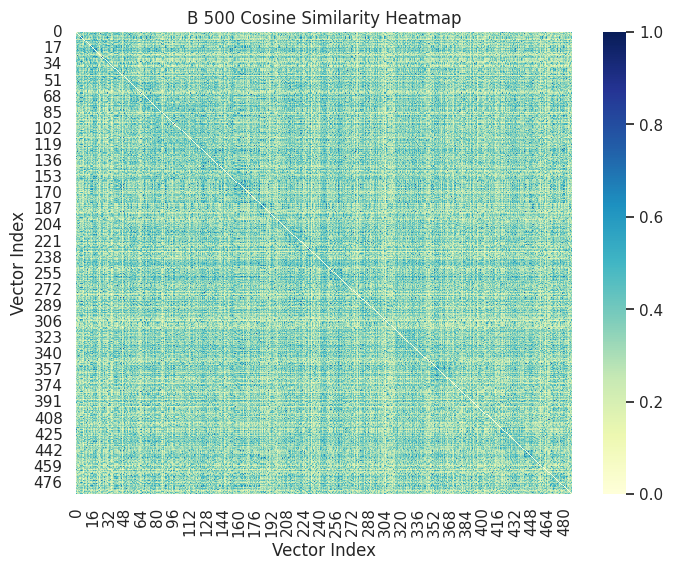

In [ ]:
# Create heatmap
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
sns.heatmap(b500_similarity_matrix, cmap="YlGnBu", vmin=0, vmax=1)
plt.title("B 500 Cosine Similarity Heatmap")
plt.xlabel("Vector Index")
plt.ylabel("Vector Index")
plt.xticks(rotation=90)  # Rotate x-axis labels if needed
plt.yticks(rotation=0)  # Rotate y-axis labels if needed
plt.show()

In [ ]:
# Get TSNE

# Convert the industry_list to a NumPy array
b500_result_array = np.array(b500_result)

# Perform t-SNE on the b500_result embeddings to reduce the dimensionality to 2D
tsne = TSNE(n_components=2, perplexity=9, random_state=42)
b500_embeddings_2d = tsne.fit_transform(b500_result_array)

# Create a DataFrame for visualization
tsne_df = pd.DataFrame(b500_embeddings_2d, columns=['x coord (TSNE)', 'y coord (TSNE)'])
tsne_df['label'] = industry_list

# Plot the t-SNE visualization for sample_result embeddings using Plotly Express
fig = px.scatter(
    tsne_df, x='x coord (TSNE)', y='y coord (TSNE)',
    color='label', labels={'color': 'label'},
    hover_data=[data['Company Name']],
    title="t-SNE Visualization of Bloomberg 500 Result Embeddings"
)
fig.show()


In [ ]:
#get the cosine similarity between all the Utilities company description vectors"
utilities_similarities = []
utilities_similarity_matrix = np.zeros((len(utilities_result), len(utilities_result)))
for i in range(len(utilities_result)):
    for j in range(i + 1, len(utilities_result)):
        utilities_similarity = get_cosine_similarity(np.array(utilities_result[i]), np.array(utilities_result[j]))
        utilities_similarities.append((i, j, utilities_similarity))
        utilities_similarity_matrix[i, j] = utilities_similarity
        utilities_similarity_matrix[j, i] = utilities_similarity

utilities_similarities.sort(key=lambda x: x[2], reverse=True)

# Print top 10 similarities with indices
print("Top 10 Similarities:")
for i in range(10):
    index_1, index_2, similarity = utilities_similarities[i]
    print(f"Similarity: {similarity:.4f} | {utilities_company_list[index_1]} and {utilities_company_list[index_2]}")

Top 10 Similarities:
Similarity: 0.7690 | Eversource Energy and Evergy Inc
Similarity: 0.7542 | Constellation Energy Corp and Dominion Energy Inc
Similarity: 0.7512 | Entergy Corp and FirstEnergy Corp
Similarity: 0.7351 | Dominion Energy Inc and Duke Energy Corp
Similarity: 0.7324 | Constellation Energy Corp and FirstEnergy Corp
Similarity: 0.7209 | Dominion Energy Inc and DTE Energy Co
Similarity: 0.7198 | Constellation Energy Corp and Entergy Corp
Similarity: 0.7054 | Entergy Corp and Evergy Inc
Similarity: 0.7008 | Atmos Energy Corp and Xcel Energy Inc
Similarity: 0.6987 | Dominion Energy Inc and Entergy Corp


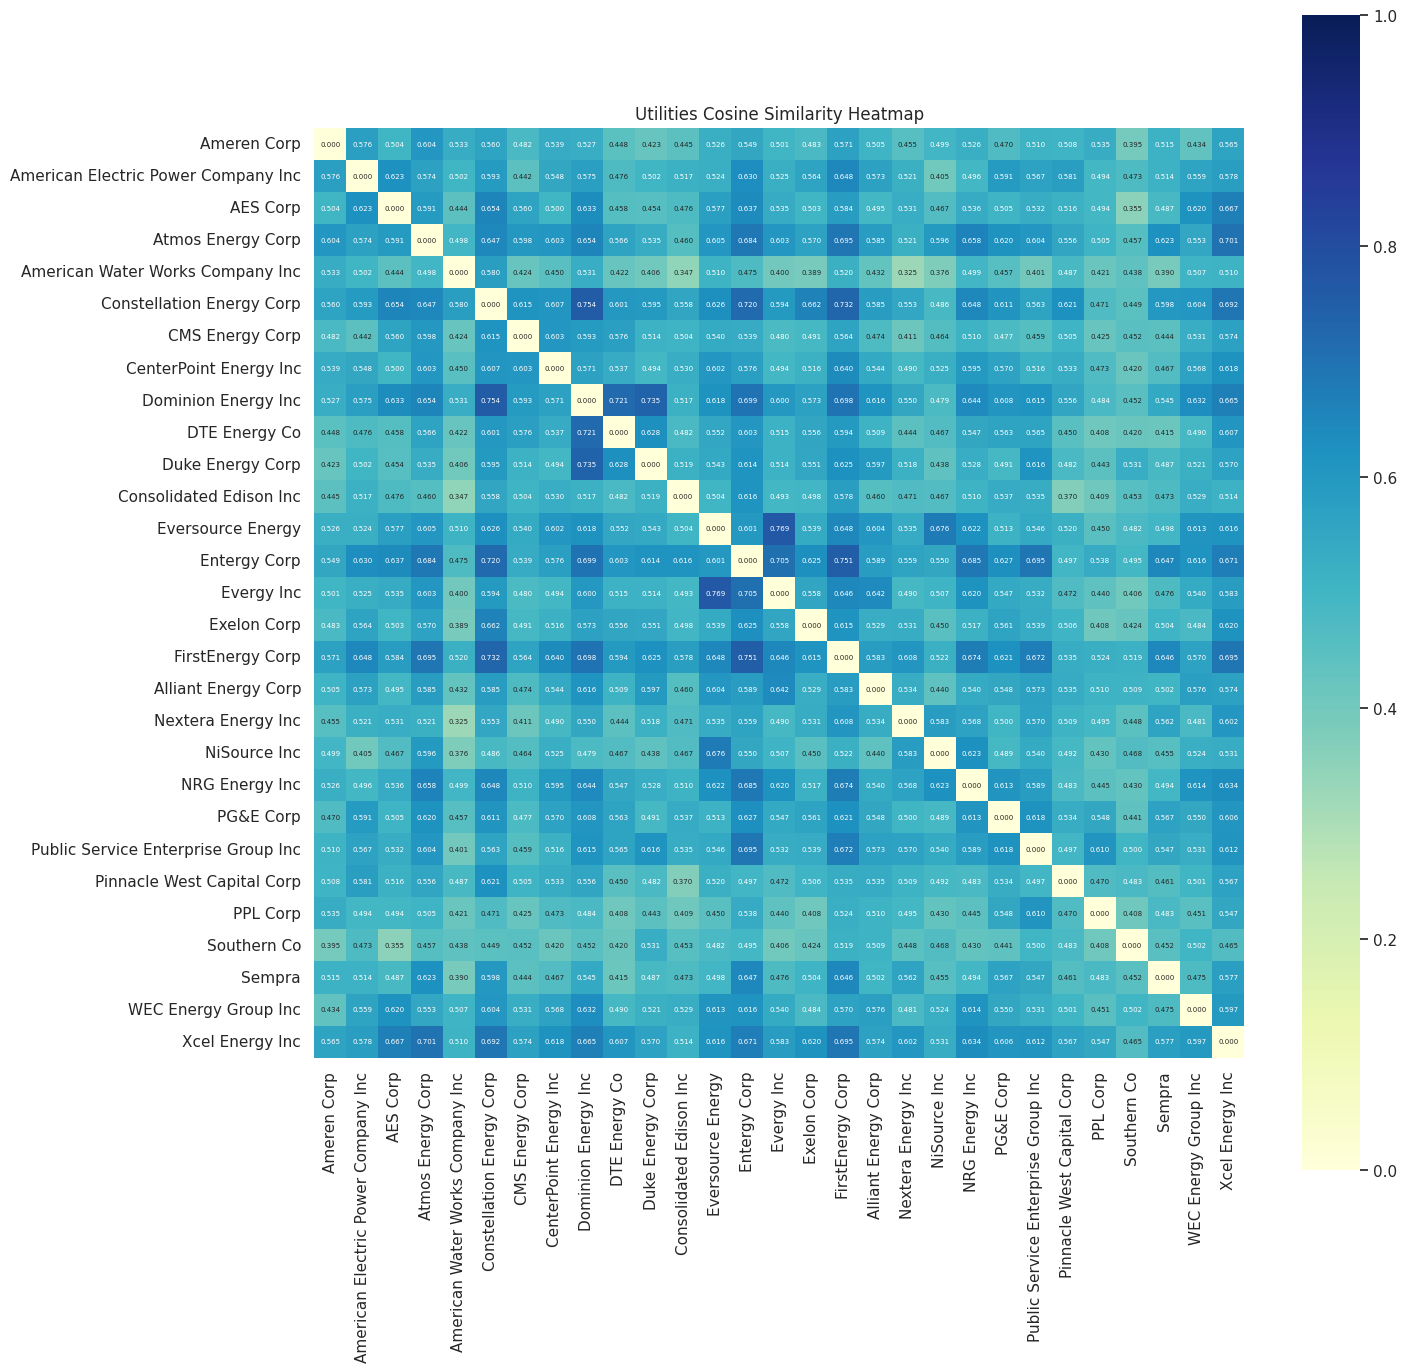

In [ ]:
#get heatmap
plt.figure(figsize=(15, 15))  # Adjust the figure size as needed
sns.heatmap(utilities_similarity_matrix, cmap="YlGnBu", annot=True,
                  square=True,
                  fmt='.3f',
                  annot_kws={'size': 5},
                  yticklabels=utilities_company_list,
                  xticklabels=utilities_company_list,
                  vmin=0, vmax=1)
plt.title("Utilities Cosine Similarity Heatmap")
sns.set(font_scale=0.5)
plt.show()

In [ ]:
# Get TSNE

# Convert the industry_list to a NumPy array
utilities_result_array = np.array(utilities_result)

# Perform t-SNE on the b500_result embeddings to reduce the dimensionality to 2D
tsne = TSNE(n_components=2, perplexity=9, random_state=42)
utilities_embeddings_2d = tsne.fit_transform(utilities_result_array)

# Create a DataFrame for visualization
tsne_df = pd.DataFrame(utilities_embeddings_2d, columns=['x coord (TSNE)', 'y coord (TSNE)'])
tsne_df['label'] = utilities_industry_list

# Plot the t-SNE visualization for sample_result embeddings using Plotly Express
fig = px.scatter(
    tsne_df, x='x coord (TSNE)', y='y coord (TSNE)',
    color='label', labels={'color': 'label'},
    hover_data=[Utilities_companies['GICS Sector Name']],
    title="t-SNE Visualization of Utilities Companies from Bloomberg 500 Result Embeddings"
)
fig.show()


Try to find if the model performs differently in different sectors

### Approximate Nearest Neighbors

#### Angular

In [ ]:
from annoy import AnnoyIndex

f = len(b500_result[0])
t = AnnoyIndex(f, 'angular')
for i in range(len(b500_result)):
    t.add_item(i, b500_result[i])

t.build(10)
t.save('b500.ann')

True

In [ ]:
new_sentence = "Amazon.com, Inc. provides a range of products and services to customers. The products offered through its stores include merchandise and content that it purchased for resale and products offered by third-party sellers. It manufactures and sells electronic devices, including Kindle, Fire tablet, Fire TV, Echo, and Ring, and it develops and produces media content. It also offers subscription services such as Amazon Prime, a membership program. Its segments include North America, International and Amazon Web Services (AWS). The AWS segment consists of global sales of compute, storage, database, and other services for start-ups, enterprises, government agencies, and academic institutions. It provides advertising services to sellers, vendors, publishers, authors, and others, through programs, such as sponsored advertisements, display, and video advertising. Customers access its offerings through websites, mobile applications, Alexa, devices, streaming, and physically visiting its stores."
new_embedding = hf_embeddings.embed_documents([new_sentence])

In [ ]:
u = AnnoyIndex(f, 'angular')
u.load('b500.ann')

True

In [ ]:
indices = u.get_nns_by_vector(new_embedding[0], 10)

In [ ]:
nearest_sentences = [data['biz_summary'].tolist()[i] for i in indices]
for sentence in nearest_sentences:
    print(sentence)

Amazon.com, Inc. is a customer-centric company operating in three segments: North America, International, and Amazon Web Services (AWS). It serves a wide range of customers and focuses on selection, price, and convenience. The company offers a vast array of products through online and physical stores, manufactures electronic devices, and develops media content. Amazon strives to provide low prices, fast delivery, easy functionality, and timely customer service. It faces intense competition globally, with key factors being selection, price, convenience, and fulfillment reliability. Amazon relies on intellectual property rights and protection measures. It experiences seasonality, with higher sales during the fourth quarter. Human capital is crucial, and the company invests in talent development and engagement. The executive team is led by Jeffrey P. Bezos as Executive Chair and Andrew R. Jassy as President and CEO. Overall, Amazon's customer-centric approach, diverse offerings, and focus

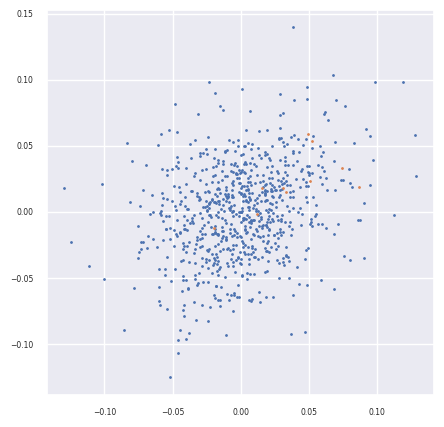

In [ ]:
plt.figure(figsize=(5, 5))
plt.scatter(b500_result[:][0], b500_result[:][1], s=1)
subset = [b500_result[i] for i in indices]
plt.scatter([point[0] for point in subset], [point[1] for point in subset], s=1)
#subset = b500_result[indices[:]]
#plt.scatter(subset[:, 0], subset[:, 1], s=1)4

In [ ]:
test_similarities = []
for i in range(len(b500_result)):
      similarity = get_cosine_similarity_2(np.array(b500_result[i]), new_embedding)
      test_similarities.append((i, similarity))

In [ ]:
test_similarities.sort(key=lambda x: x[1], reverse=True)

# Print top 5 similarities with index
print("Top 10 Similarities:")
for i in range(10):
  index, similarity = test_similarities[i]
  print(f"Similarity: {similarity:.4f} | {company_list[index]}")

Top 10 Similarities:
Similarity: 0.7798 | Amazon.com Inc
Similarity: 0.5657 | eBay Inc
Similarity: 0.5057 | Best Buy Co Inc
Similarity: 0.5005 | Walmart Inc
Similarity: 0.4859 | Apple Inc
Similarity: 0.4788 | AT&T Inc
Similarity: 0.4781 | Netflix Inc
Similarity: 0.4769 | Comcast Corp
Similarity: 0.4679 | Salesforce Inc
Similarity: 0.4652 | ETSY Inc


#### Euclidean

In [ ]:
t_e = AnnoyIndex(f, 'euclidean')
for i in range(len(b500_result)):
    t_e.add_item(i, b500_result[i])

t_e.build(10)
t_e.save('b500.ann')

True

In [ ]:
u_e = AnnoyIndex(f, 'euclidean')
u_e.load('b500.ann')

True

In [ ]:
indices_e = u_e.get_nns_by_vector(new_embedding[0], 10)

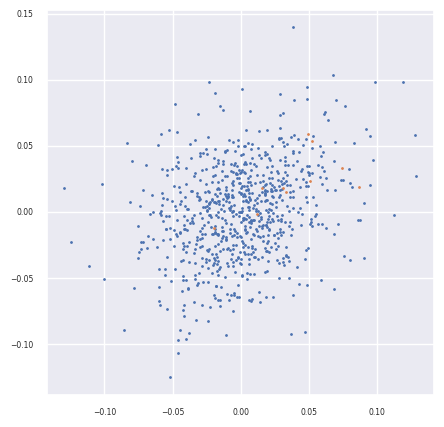

In [ ]:
plt.figure(figsize=(5, 5))
plt.scatter(b500_result[:][0], b500_result[:][1], s=1)
subset_e = [b500_result[i] for i in indices_e]
plt.scatter([point[0] for point in subset_e], [point[1] for point in subset_e], s=1)
#subset = b500_result[indices[:]]
#plt.scatter(subset[:, 0], subset[:, 1], s=1)

In [ ]:
nearest_sentences_e = [data['biz_summary'].tolist()[i] for i in indices_e]
for sentence in nearest_sentences_e:
    print(sentence)

Amazon.com, Inc. is a customer-centric company operating in three segments: North America, International, and Amazon Web Services (AWS). It serves a wide range of customers and focuses on selection, price, and convenience. The company offers a vast array of products through online and physical stores, manufactures electronic devices, and develops media content. Amazon strives to provide low prices, fast delivery, easy functionality, and timely customer service. It faces intense competition globally, with key factors being selection, price, convenience, and fulfillment reliability. Amazon relies on intellectual property rights and protection measures. It experiences seasonality, with higher sales during the fourth quarter. Human capital is crucial, and the company invests in talent development and engagement. The executive team is led by Jeffrey P. Bezos as Executive Chair and Andrew R. Jassy as President and CEO. Overall, Amazon's customer-centric approach, diverse offerings, and focus

Angular and Euclidean give the same result

## Sub-Industry classification

### K-means

In [ ]:
n_clusters = 5

In [ ]:
data.head(3)

,Ticker Symbol,biz_summary,Identifier,Company Name,GICS Sector Name,GICS Industry Group Name,GICS Industry Name,GICS Sub-Industry Name,GICS Sector Code,GICS Industry Group Code,GICS Industry Code,GICS Sub-Industry Code
0,A,Agilent Technologies Inc. is a global leader i...,A.N,Agilent Technologies Inc,Health Care,"Pharmaceuticals, Biotechnology & Life Sciences",Life Sciences Tools & Services,Life Sciences Tools & Services,35,"3,520","352,030","35,203,010"
1,AAL,American Airlines Group Inc. (AAG) is a major ...,AAL.OQ,American Airlines Group Inc,Industrials,Transportation,Passenger Airlines,Passenger Airlines,20,"2,030","203,020","20,302,010"
2,AAP,"Advance Auto Parts, Inc. is a leading automoti...",AAP.N,Advance Auto Parts Inc,Consumer Discretionary,Consumer Discretionary Distribution & Retail,Specialty Retail,Automotive Retail,25,"2,550","255,040","25,504,050"


In [ ]:
grouped_df = data.groupby('GICS Sector Name')
group_dict = {}
for name, group in grouped_df:
    group_dict[name] = list(zip(group['biz_summary'].values.tolist(), group['Company Name'].values.tolist()))

In [ ]:
clusters_dict = {}
for key, value in group_dict.items():
    descriptions = [v[0] for v in value]
    # Create embeddings for each industry sector
    group_embed = hf_embeddings.embed_documents(descriptions)
    kmeans = KMeans(n_clusters=n_clusters, n_init=10)
    kmeans.fit(group_embed)
    labels = kmeans.labels_
    sub_clusters = {i: [] for i in range(n_clusters)}
    for i, label in enumerate(labels):
        sub_clusters[label].append(value[i])
    clusters_dict[key] = sub_clusters

In [ ]:
flattened_data = []

for industry, subgroups in clusters_dict.items():
    for subgroup, descriptions in subgroups.items():
        for description, company in descriptions:
            flattened_data.append({
                'industry': industry,
                'subgroup': subgroup,
                'description': description,
                'company': company,
            })

subIndustry_df = pd.DataFrame(flattened_data)


In [ ]:
subIndustry_df.head(3)

,industry,subgroup,description,company
0,Communication Services,0,Charter Communications is a leading broadband ...,Charter Communications Inc
1,Communication Services,0,"AT&T Inc. is a global telecommunications, medi...",AT&T Inc
2,Communication Services,0,T-Mobile is a leading wireless communications ...,T-Mobile US Inc


In [ ]:
data_subindustry = data.merge(subIndustry_df, left_on='Company Name', right_on='company', how='inner')
data_subindustry.head(3)

,Ticker Symbol,biz_summary,Identifier,Company Name,GICS Sector Name,GICS Industry Group Name,GICS Industry Name,GICS Sub-Industry Name,GICS Sector Code,GICS Industry Group Code,GICS Industry Code,GICS Sub-Industry Code,industry,subgroup,description,company
0,A,Agilent Technologies Inc. is a global leader i...,A.N,Agilent Technologies Inc,Health Care,"Pharmaceuticals, Biotechnology & Life Sciences",Life Sciences Tools & Services,Life Sciences Tools & Services,35,"3,520","352,030","35,203,010",Health Care,0,Agilent Technologies Inc. is a global leader i...,Agilent Technologies Inc
1,AAL,American Airlines Group Inc. (AAG) is a major ...,AAL.OQ,American Airlines Group Inc,Industrials,Transportation,Passenger Airlines,Passenger Airlines,20,"2,030","203,020","20,302,010",Industrials,2,American Airlines Group Inc. (AAG) is a major ...,American Airlines Group Inc
2,AAP,"Advance Auto Parts, Inc. is a leading automoti...",AAP.N,Advance Auto Parts Inc,Consumer Discretionary,Consumer Discretionary Distribution & Retail,Specialty Retail,Automotive Retail,25,"2,550","255,040","25,504,050",Consumer Discretionary,2,"Advance Auto Parts, Inc. is a leading automoti...",Advance Auto Parts Inc


In [ ]:
# Get TSNE

# Convert the industry_list to a NumPy array
b500_result_array = np.array(b500_result)

# Perform t-SNE on the b500_result embeddings to reduce the dimensionality to 2D
tsne = TSNE(n_components=2, perplexity=9, random_state=42)
b500_embeddings_2d = tsne.fit_transform(b500_result_array)

# Create a DataFrame for visualization
tsne_df = pd.DataFrame(b500_embeddings_2d, columns=['x coord (TSNE)', 'y coord (TSNE)'])
tsne_df['label'] = data_subindustry['company']
tsne_df['industry'] = data_subindustry['industry']
tsne_df['subgroup'] = data_subindustry['subgroup']
# tsne_df['subgroup'] = data_subindustry['industry'] + '-' + data_subindustry['subgroup'].astype(str)
tsne_df = tsne_df.sort_values(by='industry')

# Plot the t-SNE visualization for sample_result embeddings using Plotly Express
fig = px.scatter(
    tsne_df, x='x coord (TSNE)', y='y coord (TSNE)',
    color='industry', symbol='subgroup',
    labels={'color': 'industry', 'symbol': 'subgroup'},
    hover_data=[tsne_df['label']], # add label to hover data
    title="t-SNE Visualization K-means"
)
fig.show()

### Hierarchical Clustering

In [ ]:
n_clusters = 5

In [ ]:
grouped_df = data.groupby('GICS Sector Name')
group_dict = {}
for name, group in grouped_df:
    group_dict[name] = list(zip(group['biz_summary'].values.tolist(), group['Company Name'].values.tolist()))

In [ ]:
clusters_dict_hc = {}
for key, value in group_dict.items():
    descriptions = [v[0] for v in value]
    # Create embeddings for each industry sector
    group_embed = hf_embeddings.embed_documents(descriptions)
    similarity_matrix = cosine_similarity(group_embed)
    # Use linkage() function to cluster the similarity_matrix
    linked = linkage(similarity_matrix, 'ward')
    labels = fcluster(linked, t=n_clusters, criterion='maxclust')
    sub_clusters = {i: [] for i in range(1, n_clusters + 1)}
    for i, label in enumerate(labels):
        sub_clusters[label].append(value[i])
    clusters_dict_hc[key] = sub_clusters

In [ ]:
flattened_data_hc = []

for industry, subgroups in clusters_dict_hc.items():
    for subgroup, descriptions in subgroups.items():
        for description, company in descriptions:
            flattened_data_hc.append({
                'industry': industry,
                'subgroup': subgroup,
                'description': description,
                'company': company,
            })

subIndustry_df_hc = pd.DataFrame(flattened_data_hc)

In [ ]:
data_subindustry_hc = data.merge(subIndustry_df_hc, left_on='Company Name', right_on='company', how='inner')
data_subindustry_hc.head(3)

,Ticker Symbol,biz_summary,Identifier,Company Name,GICS Sector Name,GICS Industry Group Name,GICS Industry Name,GICS Sub-Industry Name,GICS Sector Code,GICS Industry Group Code,GICS Industry Code,GICS Sub-Industry Code,industry,subgroup,description,company
0,A,Agilent Technologies Inc. is a global leader i...,A.N,Agilent Technologies Inc,Health Care,"Pharmaceuticals, Biotechnology & Life Sciences",Life Sciences Tools & Services,Life Sciences Tools & Services,35,"3,520","352,030","35,203,010",Health Care,5,Agilent Technologies Inc. is a global leader i...,Agilent Technologies Inc
1,AAL,American Airlines Group Inc. (AAG) is a major ...,AAL.OQ,American Airlines Group Inc,Industrials,Transportation,Passenger Airlines,Passenger Airlines,20,"2,030","203,020","20,302,010",Industrials,3,American Airlines Group Inc. (AAG) is a major ...,American Airlines Group Inc
2,AAP,"Advance Auto Parts, Inc. is a leading automoti...",AAP.N,Advance Auto Parts Inc,Consumer Discretionary,Consumer Discretionary Distribution & Retail,Specialty Retail,Automotive Retail,25,"2,550","255,040","25,504,050",Consumer Discretionary,2,"Advance Auto Parts, Inc. is a leading automoti...",Advance Auto Parts Inc


In [ ]:
# Get TSNE

# Convert the industry_list to a NumPy array
b500_result_array = np.array(b500_result)

# Perform t-SNE on the b500_result embeddings to reduce the dimensionality to 2D
tsne = TSNE(n_components=2, perplexity=9, random_state=42)
b500_embeddings_2d = tsne.fit_transform(b500_result_array)

# Create a DataFrame for visualization
tsne_df = pd.DataFrame(b500_embeddings_2d, columns=['x coord (TSNE)', 'y coord (TSNE)'])
tsne_df['label'] = data_subindustry_hc['company']
tsne_df['industry'] = data_subindustry_hc['industry']
tsne_df['subgroup'] = data_subindustry_hc['subgroup']
# tsne_df['subgroup'] = data_subindustry['industry'] + '-' + data_subindustry['subgroup'].astype(str)
tsne_df = tsne_df.sort_values(by='industry')

# Plot the t-SNE visualization for sample_result embeddings using Plotly Express
fig = px.scatter(
    tsne_df, x='x coord (TSNE)', y='y coord (TSNE)',
    color='industry', symbol='subgroup',
    labels={'color': 'industry', 'symbol': 'subgroup'},
    hover_data=[tsne_df['label']], # add label to hover data
    title="t-SNE Visualization Hierarchical Clustering"
)
fig.show()

### Communication Services Sector sub-industry

#### K-means

In [ ]:
# Get TSNE

# Convert the industry_list to a NumPy array
b500_result_array = np.array(b500_result)

# Perform t-SNE on the b500_result embeddings to reduce the dimensionality to 2D
tsne = TSNE(n_components=2, perplexity=9, random_state=42)
b500_embeddings_2d = tsne.fit_transform(b500_result_array)

# Create a DataFrame for visualization
tsne_df = pd.DataFrame(b500_embeddings_2d, columns=['x coord (TSNE)', 'y coord (TSNE)'])
tsne_df['label'] = data_subindustry['company']
tsne_df['industry'] = data_subindustry['industry']
tsne_df['subgroup'] = data_subindustry['subgroup']
# tsne_df['subgroup'] = data_subindustry['industry'] + '-' + data_subindustry['subgroup'].astype(str)
tsne_df = tsne_df[tsne_df['industry'] == 'Communication Services']
tsne_df = tsne_df.sort_values(by='subgroup')


# Plot the t-SNE visualization for sample_result embeddings using Plotly Express
fig = px.scatter(
    tsne_df, x='x coord (TSNE)', y='y coord (TSNE)',
    color='subgroup',
    labels={'color': 'subgroup'},
    hover_data=[tsne_df['label']], # add label to hover data
    title="Communication t-SNE Visualization k-means"
)
fig.show()

#### Hierarchical Clustering

In [ ]:
# Get TSNE

# Convert the industry_list to a NumPy array
b500_result_array = np.array(b500_result)

# Perform t-SNE on the b500_result embeddings to reduce the dimensionality to 2D
tsne = TSNE(n_components=2, perplexity=9, random_state=42)
b500_embeddings_2d = tsne.fit_transform(b500_result_array)

# Create a DataFrame for visualization
tsne_df = pd.DataFrame(b500_embeddings_2d, columns=['x coord (TSNE)', 'y coord (TSNE)'])
tsne_df['label'] = data_subindustry_hc['company']
tsne_df['industry'] = data_subindustry_hc['industry']
tsne_df['subgroup'] = data_subindustry_hc['subgroup']
# tsne_df['subgroup'] = data_subindustry['industry'] + '-' + data_subindustry['subgroup'].astype(str)
tsne_df = tsne_df[tsne_df['industry'] == 'Communication Services']
tsne_df = tsne_df.sort_values(by='subgroup')


# Plot the t-SNE visualization for sample_result embeddings using Plotly Express
fig = px.scatter(
    tsne_df, x='x coord (TSNE)', y='y coord (TSNE)',
    color='subgroup',
    labels={'color': 'subgroup'},
    hover_data=[tsne_df['label']], # add label to hover data
    title="Communication t-SNE Visualization Hierarchical"
)
fig.show()

### Industry classification using LLM

In [ ]:
grouped_sub_ind_df = data_subindustry.groupby(['industry', 'subgroup'])['biz_summary'].apply(list)

In [ ]:
prompt_template = "Can you give one universal, descriptive and specific sub-industry classification (less than 4 words) "\
    "based on the following sector information: {sector}, and list of company descriptions: {comp_desc}?" \
    "Only return you answer of the classification, do not include any other words in your answer."
llm_chain_classification = LLMChain(
    llm=llm,
    prompt=PromptTemplate.from_template(prompt_template)
)

In [ ]:
classification_llm_list = []
for (industry, subgroup), cie_des_list in grouped_sub_ind_df.items():
    output = llm_chain_classification({'sector': industry, 'comp_desc':cie_des_list})
    text = output['text']
    classification_llm_list.append((industry, subgroup, text))

In [ ]:
classification_llm = pd.DataFrame(classification_llm_list,columns=['Sector','subgroup','Sub_industry'])
classification_llm.head(3)

,Sector,subgroup,Sub_industry
0,Communication Services,0,Telecom
1,Communication Services,1,Entertainment
2,Communication Services,2,Gaming


In [ ]:
data_subindustry_name = data_subindustry_hc.merge(classification_llm, how='left', left_on=['GICS Sector Name', 'subgroup'], right_on=['Sector', 'subgroup'])

In [ ]:
# Get TSNE

# Convert the industry_list to a NumPy array
b500_result_array = np.array(b500_result)

# Perform t-SNE on the b500_result embeddings to reduce the dimensionality to 2D
tsne = TSNE(n_components=2, perplexity=9, random_state=42)
b500_embeddings_2d = tsne.fit_transform(b500_result_array)

# Create a DataFrame for visualization
tsne_df = pd.DataFrame(b500_embeddings_2d, columns=['x coord (TSNE)', 'y coord (TSNE)'])
tsne_df['label'] = data_subindustry_name['company']
tsne_df['industry'] = data_subindustry_name['industry']
tsne_df['subgroup'] = data_subindustry_name['Sub_industry']
# tsne_df['subgroup'] = data_subindustry['industry'] + '-' + data_subindustry['subgroup'].astype(str)
tsne_df = tsne_df.sort_values(by='industry')

# Plot the t-SNE visualization for sample_result embeddings using Plotly Express
fig = px.scatter(
    tsne_df, x='x coord (TSNE)', y='y coord (TSNE)',
    color='industry', symbol='subgroup',
    labels={'color': 'industry', 'symbol': 'subgroup'},
    hover_data=[tsne_df['label']], # add label to hover data
    title="t-SNE Visualization with LLM sub industry"
)
fig.show()

In [ ]:
# Get TSNE

# Convert the industry_list to a NumPy array
b500_result_array = np.array(b500_result)

# Perform t-SNE on the b500_result embeddings to reduce the dimensionality to 2D
tsne = TSNE(n_components=2, perplexity=9, random_state=42)
b500_embeddings_2d = tsne.fit_transform(b500_result_array)

# Create a DataFrame for visualization
tsne_df = pd.DataFrame(b500_embeddings_2d, columns=['x coord (TSNE)', 'y coord (TSNE)'])
tsne_df['label'] = data_subindustry_name['company']
tsne_df['industry'] = data_subindustry_name['industry']
tsne_df['subgroup'] = data_subindustry_name['GICS Industry Group Name']
# tsne_df['subgroup'] = data_subindustry['industry'] + '-' + data_subindustry['subgroup'].astype(str)
tsne_df = tsne_df.sort_values(by='industry')

# Plot the t-SNE visualization for sample_result embeddings using Plotly Express
fig = px.scatter(
    tsne_df, x='x coord (TSNE)', y='y coord (TSNE)',
    color='industry', symbol='subgroup',
    labels={'color': 'industry', 'symbol': 'subgroup'},
    hover_data=[tsne_df['label']], # add label to hover data
    title="t-SNE Visualization with GICS Industry Group"
)
fig.show()

#### Financial Sector sub industry comparison (LLM vs GICS)

In [ ]:
# Convert the industry_list to a NumPy array
b500_result_array = np.array(b500_result)

# Perform t-SNE on the b500_result embeddings to reduce the dimensionality to 2D
tsne = TSNE(n_components=2, perplexity=9, random_state=42)
b500_embeddings_2d = tsne.fit_transform(b500_result_array)

# Create a DataFrame for visualization
tsne_df = pd.DataFrame(b500_embeddings_2d, columns=['x coord (TSNE)', 'y coord (TSNE)'])
tsne_df['label'] = data_subindustry_name['company']
tsne_df['industry'] = data_subindustry_name['industry']

# Plot1
tsne_df['subgroup'] = data_subindustry_name['Sub_industry']
tsne_df1 = tsne_df[tsne_df['industry'] == 'Financials'].sort_values(by='subgroup')
fig1 = px.scatter(tsne_df1, x='x coord (TSNE)', y='y coord (TSNE)', color='subgroup',
                 labels={'color': 'subgroup'}, hover_data=[tsne_df1['label']],
                 title="t-SNE Visualization for Financial Sector generated by LLM")
# Adjust labels to differentiate from the second plot
for trace in fig1.data:
    trace.name += ' (LLM)'

# Plot2
tsne_df['subgroup'] = data_subindustry_name['GICS Industry Group Name']
tsne_df2 = tsne_df[tsne_df['industry'] == 'Financials'].sort_values(by='subgroup')
fig2 = px.scatter(tsne_df2, x='x coord (TSNE)', y='y coord (TSNE)', color='subgroup',
                 labels={'color': 'subgroup'}, hover_data=[tsne_df2['label']],
                 title="t-SNE Visualization for Financial Sector by GICS")
# Adjust labels to differentiate from the first plot
for trace in fig2.data:
    trace.name += ' (GICS)'

# Create a subplot layout
subplot_fig = make_subplots(rows=1, cols=2, subplot_titles=('LLM', 'GICS'))
for trace in fig1['data']:
    subplot_fig.add_trace(trace, row=1, col=1)
for trace in fig2['data']:
    subplot_fig.add_trace(trace, row=1, col=2)

subplot_fig.show()

# Building Relative Valuation Chatbot

## Creating a Vector Database Class
Incorporating modules for data import, preprocessing, embedding, and index creation.

In [ ]:
class Data2Vec:
  embeddings: object = None
  # model_name = SentenceTransformer('all-mpnet-base-v2', device='cuda' if torch.cuda.is_available() else 'cpu')

  def __init__(self, top_k_=5, model_name_=None, score = True) -> None:
    if not model_name_:
      model_name = "sentence-transformers/all-mpnet-base-v2"
      model_kwargs = {'device': 'cuda'} if torch.cuda.is_available() else {'device': 'cpu'}
      encode_kwargs = {'normalize_embeddings': False}
      hf_embeddings = HuggingFaceEmbeddings(
          model_name=model_name,
          model_kwargs=model_kwargs,
          encode_kwargs=encode_kwargs
      )
      self.top_k: int = top_k_
      self.embeddings = hf_embeddings
      self.document = None
      self.vec_index = None
      self.index_type = None
      self.score = score

  def init_document(self,mode,source):
    if mode == 'local':
      self.document = self.load_document_local(source)
    if mode == 'url':
      self.document = self.load_document_url(source)
    if mode == 'aws':
      self.document = self.load_document_aws(source)

  def load_document_local(self, path):
    input_df = pd.read_csv(path)
    loader = DataFrameLoader(input_df, page_content_column="biz_summary")
    data = loader.load()
    return data

  def load_document_url(self,url):
    input_df = pd.read_csv(url)
    loader = DataFrameLoader(input_df, page_content_column="biz_summary")
    data = loader.load()
    return data

  def load_document_aws(self,aws_client):
    s3obj = aws_client.Bucket('nyu-bbg-capstone').Object('RV_dataset.csv').get()
    input_df = pd.read_csv(s3obj['Body'], index_col=0)
    loader = DataFrameLoader(input_df, page_content_column="biz_summary")
    data = loader.load()
    return data

  def get_document(self):
    return self.document

  def get_vector_store(self):
    return self.vec_index

  def create_index(self,method='ann'):
    doc_list = []
    for doc in self.document:
      doc_list.append(doc.page_content)
    if method == 'ann':
      embed = self.embeddings.embed_documents(doc_list)
      dim = len(embed[0])
      ann_index = AnnoyIndex(dim, 'angular')
      for i in range(len(embed)):
          ann_index.add_item(i, embed[i])
      ann_index.build(10)
      # ann_index.save('b500.ann')
      # ann_index_load = AnnoyIndex(f, 'angular')
      # ann_index_load.load('b500.ann')
      # self.vec_index = ann_index_load
      self.vec_index = ann_index
      self.index_type = 'ann'
    if method == 'db':
      self.vec_index = Chroma.from_documents(documents = self.document, embedding = self.embeddings)
      # self.vec_index = FAISS.from_documents(documents = self.document, embedding = self.embeddings)
      self.index_type = 'db'

  def query(self, q):
    if self.index_type == 'db' and self.score == True:
      results = self.vec_index.similarity_search_with_score(q, k=self.top_k, include_metadata=True)
    if self.index_type == 'db' and self.score == False:
      results = self.vec_index.similarity_search(q, k=self.top_k, include_metadata=True)
    if self.index_type == 'ann':
      new_embed = self.embeddings.embed_documents([q])
      indices = self.vec_index.get_nns_by_vector(new_embed[0], self.top_k)
      results = [self.document[i] for i in indices]
    return results

In [ ]:
d2v = Data2Vec(10)
d2v.init_document('aws',s3client)
d2v.create_index('ann')
results = d2v.query("Amazon.com, Inc. provides a range of products and services to customers. The products offered through its stores include merchandise and content that it purchased for resale and products offered by third-party sellers. It manufactures and sells electronic devices, including Kindle, Fire tablet, Fire TV, Echo, and Ring, and it develops and produces media content. It also offers subscription services such as Amazon Prime, a membership program. Its segments include North America, International and Amazon Web Services (AWS). The AWS segment consists of global sales of compute, storage, database, and other services for start-ups, enterprises, government agencies, and academic institutions. It provides advertising services to sellers, vendors, publishers, authors, and others, through programs, such as sponsored advertisements, display, and video advertising. Customers access its offerings through websites, mobile applications, Alexa, devices, streaming, and physically visiting its stores.")

In [ ]:
for item in results:
  print(f"{item.metadata}")

{'Identifier': 'AMZN.OQ', 'Company Name': 'Amazon.com Inc', 'GICS Sector Name': 'Consumer Discretionary', 'GICS Industry Group Name': 'Consumer Discretionary Distribution & Retail', 'GICS Industry Name': 'Broadline Retail', 'GICS Sub-Industry Name': 'Broadline Retail', 'GICS Sector Code': 25, 'GICS Industry Group Code': '2,550', 'GICS Industry Code': '255,030', 'GICS Sub-Industry Code': '25,503,030'}
{'Identifier': 'EBAY.OQ', 'Company Name': 'eBay Inc', 'GICS Sector Name': 'Consumer Discretionary', 'GICS Industry Group Name': 'Consumer Discretionary Distribution & Retail', 'GICS Industry Name': 'Broadline Retail', 'GICS Sub-Industry Name': 'Broadline Retail', 'GICS Sector Code': 25, 'GICS Industry Group Code': '2,550', 'GICS Industry Code': '255,030', 'GICS Sub-Industry Code': '25,503,030'}
{'Identifier': 'BBY.N', 'Company Name': 'Best Buy Co Inc', 'GICS Sector Name': 'Consumer Discretionary', 'GICS Industry Group Name': 'Consumer Discretionary Distribution & Retail', 'GICS Industry Na

In [ ]:
d2v_db = Data2Vec(100)
d2v_db.init_document('aws',s3client)
d2v_db.create_index('db')
results_db = d2v_db.query("Amazon.com, Inc. provides a range of products and services to customers. The products offered through its stores include merchandise and content that it purchased for resale and products offered by third-party sellers. It manufactures and sells electronic devices, including Kindle, Fire tablet, Fire TV, Echo, and Ring, and it develops and produces media content. It also offers subscription services such as Amazon Prime, a membership program. Its segments include North America, International and Amazon Web Services (AWS). The AWS segment consists of global sales of compute, storage, database, and other services for start-ups, enterprises, government agencies, and academic institutions. It provides advertising services to sellers, vendors, publishers, authors, and others, through programs, such as sponsored advertisements, display, and video advertising. Customers access its offerings through websites, mobile applications, Alexa, devices, streaming, and physically visiting its stores.")
score_list = []
for doc, score in results_db:
  score_list.append(score)
  # print(f"{np.round(score, 2)}: {doc.metadata}")

## Similarity Score Cutoff Point

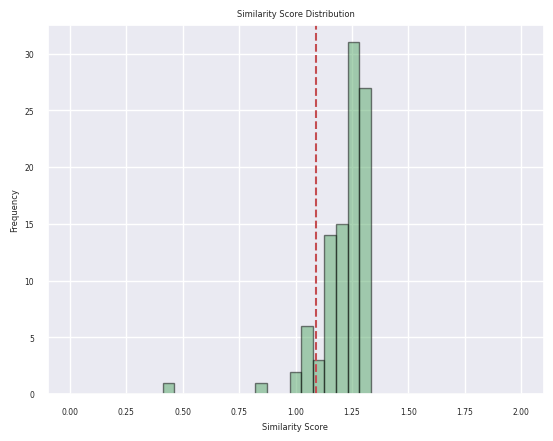

In [ ]:
bins = np.linspace(0, 2, 40)

plt.hist(score_list, bins, alpha=0.5, color='g', edgecolor='black')

plt.title('Similarity Score Distribution')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')

top_10 = np.percentile(score_list, 10)
cutoff = top_10

plt.axvline(x=cutoff, color='r', linestyle='--')

plt.show()

In [ ]:
count = len([value for value in score_list if value < top_10])
count

10

In [ ]:
score_list[10]

1.091808795928955

In [ ]:
d2v_db_eng = Data2Vec(100)
d2v_db_eng.init_document('aws',s3client)
d2v_db_eng.create_index('db')
results_db_eng = d2v_db_eng.query("Petroleo Brasileiro S.A.-Petrobras specializes in the oil, natural gas and energy industry. The Company is engaged in prospecting, drilling, refining, processing, trading and transporting crude oil from producing onshore and offshore oil fields and from shale or other rocks. Its segments include Exploration and Production, which covers the activities of exploration, development and production of crude oil, natural gas liquid and natural gas; Refining, Transportation and Marketing, which covers the refining, logistics, transport and trading of crude oil and oil products activities, exporting of ethanol, and extraction and processing of shale; Gas and Power, which is engaged in transportation and trading of natural gas produced in Brazil and imported natural gas; Biofuels, which covers the activities of production of biodiesel and its co-products, and ethanol-related activities; Distribution, which includes the activities of its subsidiary Petrobras Distribuidora S.A., and Corporate.")
score_list_eng  = []
for doc, score in results_db_eng:
  score_list_eng .append(score)
  # print(f"{np.round(score, 2)}: {doc.metadata}")

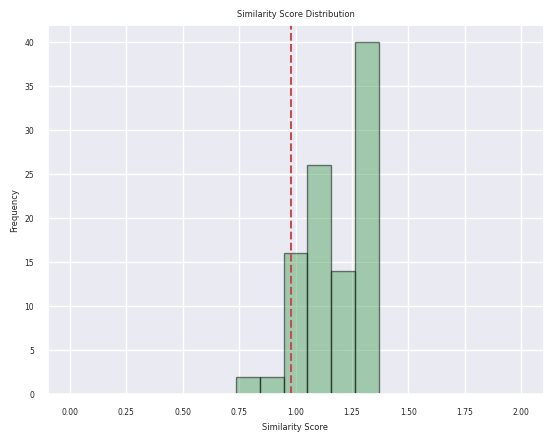

In [ ]:
bins = np.linspace(0, 2, 20)

plt.hist(score_list_eng, bins, alpha=0.5, color='g', edgecolor='black')

plt.title('Similarity Score Distribution')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')

top_10_eng = np.percentile(score_list_eng, 10)
cutoff = top_10_eng

plt.axvline(x=cutoff, color='r', linestyle='--')

plt.show()

In [ ]:
count = len([value for value in score_list_eng if value < top_10_eng])
count

10

## Building Custom Agent for retrieval

In [ ]:
llm = ChatOpenAI(model_name = 'gpt-3.5-turbo-16k', temperature=0,openai_api_key=os.environ['OPENAI_TOKEN'])

### Single Action Agent

In [ ]:
d2v_custom = Data2Vec(10)
d2v_custom.init_document('aws',s3client)
d2v_custom.create_index('db')

In [ ]:
tools = [
    Tool(
        name = "Search",
        func=d2v_custom.query,
        description="useful for when you need to answer questions about relative valuation",
        # return_direct = True
    )
]

In [ ]:
# Set up the base template
template = """Answer the following questions as best you can, but speaking as a financial analyst might speak.
            You have access to the following tools:

{tools}

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can only repeat 1 time)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Only give your final answer with companies' metadata, company name and their sector.
Do not include your own recommendation/analysis in the final answer.

Question: {input}
{agent_scratchpad}"""

In [ ]:
# Set up a prompt template
class CustomPromptTemplate(StringPromptTemplate):
    # The template to use
    template: str
    # The list of tools available
    tools: List[Tool]

    def format(self, **kwargs) -> str:
        # Get the intermediate steps (AgentAction, Observation tuples)
        # Format them in a particular way
        intermediate_steps = kwargs.pop("intermediate_steps")
        thoughts = ""
        for action, observation in intermediate_steps:
            thoughts += action.log
            thoughts += f"\nObservation: {observation}\nThought: "
        # Set the agent_scratchpad variable to that value
        kwargs["agent_scratchpad"] = thoughts
        # Create a tools variable from the list of tools provided
        kwargs["tools"] = "\n".join([f"{tool.name}: {tool.description}" for tool in self.tools])
        # Create a list of tool names for the tools provided
        kwargs["tool_names"] = ", ".join([tool.name for tool in self.tools])
        return self.template.format(**kwargs)

In [ ]:
class CustomOutputParser(AgentOutputParser):

    def parse(self, llm_output: str) -> Union[AgentAction, AgentFinish]:
        # Check if agent should finish
        if "Final Answer:" in llm_output:
            return AgentFinish(
                # Return values is generally always a dictionary with a single `output` key
                # It is not recommended to try anything else at the moment :)
                return_values={"output": llm_output.split("Final Answer:")[-1].strip()},
                log=llm_output,
            )
        # Parse out the action and action input
        regex = r"Action\s*\d*\s*:(.*?)\nAction\s*\d*\s*Input\s*\d*\s*:[\s]*(.*)"
        match = re.search(regex, llm_output, re.DOTALL)
        if not match:
            raise OutputParserException(f"Could not parse LLM output: `{llm_output}`")
        action = match.group(1).strip()
        action_input = match.group(2)
        # Return the action and action input
        return AgentAction(tool=action, tool_input=action_input.strip(" ").strip('"'), log=llm_output)

In [ ]:
prompt = CustomPromptTemplate(
    template=template,
    tools=tools,
    # This omits the `agent_scratchpad`, `tools`, and `tool_names` variables because those are generated dynamically
    # This includes the `intermediate_steps` variable because that is needed
    input_variables=["input", "intermediate_steps"]
)

In [ ]:
output_parser = CustomOutputParser()

In [ ]:
llm_chain = LLMChain(llm=llm, prompt=prompt)

In [ ]:
tool_names = [tool.name for tool in tools]
agent = LLMSingleActionAgent(
    llm_chain=llm_chain,
    output_parser=output_parser,
    stop=["\nObservation:"],
    allowed_tools=tool_names
)

In [ ]:
agent_executor = AgentExecutor.from_agent_and_tools(agent=agent, tools=tools, verbose=True)

In [ ]:
res = agent_executor.run("Find companies for relative valuation: 'Amazon.com, Inc. provides a range of products and services to customers. The products offered through its stores include merchandise and content that it purchased for resale and products offered by third-party sellers. It manufactures and sells electronic devices, including Kindle, Fire tablet, Fire TV, Echo, and Ring, and it develops and produces media content. It also offers subscription services such as Amazon Prime, a membership program. Its segments include North America, International and Amazon Web Services (AWS). The AWS segment consists of global sales of compute, storage, database, and other services for start-ups, enterprises, government agencies, and academic institutions. It provides advertising services to sellers, vendors, publishers, authors, and others, through programs, such as sponsored advertisements, display, and video advertising. Customers access its offerings through websites, mobile applications, Alexa, devices, streaming, and physically visiting its stores.'")



> Entering new AgentExecutor chain...
Thought: To find companies for relative valuation, I need to identify companies that are similar to Amazon.com in terms of their products and services.
Action: Search
Action Input: "companies similar to Amazon.com in terms of products and services"

Observation:[(Document(page_content="Amazon.com, Inc. is a customer-centric company operating in three segments: North America, International, and Amazon Web Services (AWS). It serves a wide range of customers and focuses on selection, price, and convenience. The company offers a vast array of products through online and physical stores, manufactures electronic devices, and develops media content. Amazon strives to provide low prices, fast delivery, easy functionality, and timely customer service. It faces intense competition globally, with key factors being selection, price, convenience, and fulfillment reliability. Amazon relies on intellectual property rights and protection measures. It experiences

In [ ]:
wrapped_lines = [textwrap.fill(line, width=50) for line in res.splitlines()]
wrapped_text = '\n'.join(wrapped_lines)
print(wrapped_text)

The companies for relative valuation that are
similar to Amazon.com are Best Buy Co Inc, eBay
Inc, and Walmart Inc.


### Single Action Chatbot with GUI

In [ ]:
input_rv = gr.components.Textbox(label="Provide company description for relative valuation")
output_rv = gr.components.Textbox(label="Company for relative valuation")

interface = gr.Interface(
    fn=agent_executor.run,
    inputs=input_rv,
    outputs=output_rv,
    title="RV Chatbot",
    description="Chatbot that helps to identify companies that could use for relative valuation",
).launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://1d0ec3635bb2e87d0e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


### Summarize the user input using Map Reduce and integrate into graph

In [ ]:
temp_des =  "Alibaba Group Holding Ltd (Alibaba Group) is a provider of technology infrastructure and marketing each to help merchants, brands, retailers and other businesses to leverage the power of new technology to engage with their users and customers and operate in a more efficient way. The company provides fundamental infrastructure for commerce and new technology, so that they can build businesses and create value that can be shared among its ecosystem participants. Its businesses comprise core commerce, China commerce, international commerce, local consumer. Cainiao, digital media and entertainment, AgentAction cloud computing and other innovation initiatives. AlibabaGroup provides services through its subsidiaries including Taobao, Tmall, Freshippo, Aliexpress, Lazada, Alibaba.com, 1688.com, ele.me, Youku, DingTalk, Alimama, and Alibaba Cloud. It also offers logistic services through Cainiao Network, Alibaba Group was established in 1999 by about 20 people led by Jack Ma, a former English teacher from Hangzhou, China."

In [ ]:
def summarize_and_plot(text):
  temp_summary = llm_get_summary_map_reduce(temp_des, map_reduce_chain)
  temp_embed = hf_embeddings.embed_documents([temp_summary])
  temp_embed_array = np.array(temp_embed)
  b500_result_array = np.array(b500_result)
  tsne = TSNE(n_components=2, perplexity=9, random_state=42)
  combined_array = np.concatenate((b500_result_array, temp_embed_array), axis=0)
  temp_embeddings_2d = tsne.fit_transform(combined_array)
  new_x_value = temp_embeddings_2d[-1][0]
  new_y_value = temp_embeddings_2d[-1][1]

  # Plot

  b500_result_array = np.array(b500_result)
  tsne = TSNE(n_components=2, perplexity=9, random_state=42)
  b500_embeddings_2d = tsne.fit_transform(b500_result_array)
  tsne_df = pd.DataFrame(b500_embeddings_2d, columns=['x coord (TSNE)', 'y coord (TSNE)'])
  tsne_df['label'] = data_subindustry['company']
  tsne_df['industry'] = data_subindustry['industry']
  tsne_df['subgroup'] = data_subindustry['subgroup']
  tsne_df = tsne_df.sort_values(by='industry')

  # Add a new data point to the tsne_df DataFrame
  new_data = {
      'x coord (TSNE)': [new_x_value],
      'y coord (TSNE)': [new_y_value],
      'label': ['BABA'],
      'industry': ['New'],
      'subgroup': ['New'],
      'point_size': [20],
  }
  new_df = pd.DataFrame(new_data)
  tsne_df = pd.concat([tsne_df, new_df])
  tsne_df['point_size'] = tsne_df['point_size'].fillna(3)
  fig = px.scatter(
      tsne_df, x='x coord (TSNE)', y='y coord (TSNE)',
      color='industry', symbol='subgroup',
      labels={'color': 'industry', 'symbol': 'subgroup'},
      hover_data=[tsne_df['label']],
      title="t-SNE Visualization New Data",
      size='point_size',
      size_max=20
  )
  fig.show()

In [ ]:
summarize_and_plot(temp_des)

### Multi Functions Agent with custom function

In [ ]:
def pd_agent_look_up(name: str) -> str:
  pd_agent = create_pandas_dataframe_agent(
    llm,
    data,
    verbose=True,
    agent_type=AgentType.OPENAI_FUNCTIONS,
  )
  try:
    output = pd_agent.run(f'Get me the stock ticker for company {name}, it might not be exact match')
  except OutputParserException:
    output = ''
  return output

In [ ]:
pd_agent_look_up_tool = StructuredTool.from_function(pd_agent_look_up, description = "use this tool to look for stock ticker or id")
# pd_agent_look_up_tool = StructuredTool.from_function(pd_agent_look_up)

In [ ]:
def get_stock_metrics(symbol):
    ticker = yf.Ticker(symbol)

    info = ticker.info

    market_cap_million = info.get('marketCap', None) / 1e6 if info.get('marketCap', None) is not None else None
    beta = info.get('beta', None)
    revenue_million = info.get('totalRevenue', None) / 1e6 if info.get('totalRevenue', None) is not None else None
    pe_ratio = info.get('trailingPE', None)

    enterprise_value = info.get('enterpriseValue', None)
    ebitda = info.get('ebitda', None)

    ev_ebitda = None
    if enterprise_value and ebitda:
        ev_ebitda = enterprise_value / ebitda

    return {
        'Market Cap (in Million)': market_cap_million,
        'Beta': beta,
        'Revenue (in Million)': revenue_million,
        'PE Ratio': pe_ratio,
        'EV/EBITDA': ev_ebitda
    }

In [ ]:
def get_stock_price(symbol):
    ticker = yf.Ticker(symbol)
    todays_data = ticker.history(period='1d')
    return round(todays_data['Close'][0], 2)

In [ ]:
class StockPriceCheckInput(BaseModel):
    """Input for Stock price check."""

    stockticker: str = Field(..., description="Ticker symbol for stock or index")

class StockPriceTool(BaseTool):
    name = "get_stock_ticker_price"
    description = "Useful for when you need to find out the price of stock. You should input the stock ticker used on the yfinance API"

    def _run(self, stockticker: str):
        # print("i'm running")
        price_response = get_stock_price(stockticker)

        return price_response

    def _arun(self, stockticker: str):
        raise NotImplementedError("This tool does not support async")

    args_schema: Optional[Type[BaseModel]] = StockPriceCheckInput

In [ ]:
class StockMetricsCheckInput(BaseModel):
    """Input for Stock metrics check."""

    stockticker: str = Field(..., description="Ticker symbol for stock or index")

class StockMetricsTool(BaseTool):
    name = "get_stock_ticker_financial_metrics"
    description = "Useful for when you need to find out the financial metrics of stock. You should input the stock ticker used on the yfinance API"

    def _run(self, stockticker: str):
        # print("i'm running")
        metric_response = get_stock_metrics(stockticker)

        return metric_response

    def _arun(self, stockticker: str):
        raise NotImplementedError("This tool does not support async")

    args_schema: Optional[Type[BaseModel]] = StockMetricsCheckInput

In [ ]:
class StockNameCheckInput(BaseModel):
    """Input for Stock check."""

    stockname: str = Field(..., description="Company name for stock or index")

class StockTickerTool(BaseTool):
    name = "Get_Stock_ticker_ID"
    description = "useful for when you need to get stock ticker or id for company"

    def _run(self, stockname: str):
        # print("i'm running")
        ticker_response = pd_agent_look_up(stockname)

        return ticker_response

    def _arun(self, stockname: str):
        raise NotImplementedError("This tool does not support async")

    args_schema: Optional[Type[BaseModel]] = StockNameCheckInput

In [ ]:
def custom_query(comp_input:str):
  temp_res = d2v_custom.query(comp_input)
  itemlist = []
  for item in temp_res:
    itemlist.append(item[0].metadata['Company Name'])
  return itemlist

In [ ]:
class CustomQueryCheckInput(BaseModel):
    """Input for Company description check."""

    comp_desc: str = Field(..., description="Description for a company")

class CustomQueryTool(BaseTool):
    name = "Search_Relative_Valuation"
    description = "use this tool to answer questions about relative valuation"

    def _run(self, comp_desc: str):
        # print("i'm running")
        rv_response = custom_query(comp_desc)

        return rv_response

    def _arun(self, comp_desc: str):
        raise NotImplementedError("This tool does not support async")

    args_schema: Optional[Type[BaseModel]] = CustomQueryCheckInput

In [ ]:
# custom_query_tool = StructuredTool.from_function(custom_query, description = "use this tool to answer questions about relative valuation")

In [ ]:
# stock_price_tool = StructuredTool.from_function(get_stock_price, description = "Useful for when you need to find out the price of stock. You should input the stock ticker used on the yfinance API")

In [ ]:
# tools_multi = [
#     Tool(
#         name = "Search",
#         func=custom_query,
#         description="useful for when you need to answer questions about relative valuation",
#         return_direct = True
#     ),
#     Tool(
#         name = "Get",
#         func=pd_agent_look_up_tool,
#         description="useful for when you need to get stock ticker or id for company",
#         # return_direct = True
#     )
# ]

In [ ]:
tools_multi = [
    CustomQueryTool(),
    StockTickerTool(),
    StockPriceTool(),
    StockMetricsTool(),
]

In [ ]:
# Set up the base template
# template_multi = """Answer the following questions as best you can, but speaking as a financial analyst might speak. You have access to the following tools:

# {tools}

# Use the following format:

# Question: the input question you must answer
# Thought: you should always think about what to do
# Action: the action to take, must be one of [{tool_names}]
# Action Input: the input to the action
# Observation: the result of the action
# ... (this Thought/Action/Action Input/Observation can only repeat 1 time)
# Thought: I now know the final answer
# Final Answer: the final answer to the original input question

# Begin! Remember to speak as a financial analyst when giving your final answer.
# Do not include your own recommendation/analysis in the final answer, just return the plain output from the tool

# Question: {input}
# {agent_scratchpad}"""

In [ ]:
# prompt_multi = CustomPromptTemplate(
#     template=template_multi,
#     tools=tools_multi,
#     # This omits the `agent_scratchpad`, `tools`, and `tool_names` variables because those are generated dynamically
#     # This includes the `intermediate_steps` variable because that is needed
#     input_variables=["input", "intermediate_steps"]
# )

In [ ]:
## Add Memory to the multi-tool agent
agent_kwargs = {
    "extra_prompt_messages": [MessagesPlaceholder(variable_name="chat_history")],
}
memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)

In [ ]:
agent_executor_multi = initialize_agent(
    tools_multi,
    llm,
    output_parser=output_parser,
    # agent=AgentType.STRUCTURED_CHAT_ZERO_SHOT_REACT_DESCRIPTION,
    # agent=AgentType.CONVERSATIONAL_REACT_DESCRIPTION,
    agent = AgentType.OPENAI_FUNCTIONS,
    verbose=True,
    handle_parsing_errors=True,
    max_iterations=10,
    agent_kwargs=agent_kwargs,
    memory=memory,
)

In [ ]:
agent_executor_multi.run(input="Get me the stock ID for 'Amazon.com, Inc.'")



> Entering new AgentExecutor chain...

Invoking: `Get_Stock_ticker_ID` with `{'stockname': 'Amazon.com, Inc.'}`




> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `df[df['Company Name'].str.contains('Amazon.com', case=False)]['Ticker Symbol'].values`


['AMZN']The stock ticker for Amazon.com, Inc. is "AMZN".

> Finished chain.
The stock ticker for Amazon.com, Inc. is "AMZN".The stock ID for 'Amazon.com, Inc.' is "AMZN".

> Finished chain.


'The stock ID for \'Amazon.com, Inc.\' is "AMZN".'

In [ ]:
res = agent_executor_multi.run("Search for Companies for relative valuation: 'Alibaba Group Holding Ltd (Alibaba Group) is a provider of "\
    "technology infrastructure and marketingeach to help merchants, brands, retailers and other businesses to leverage the power of"\
    "newtechnology to engage with their users and customers and operate in a more efficient way. Thecompany provides fundamental infrastructure"\
    "for commerce and new technology, so that they canbuild businesses and create value that can be shared among its ecosystem participants. "\
    "Itsbusinesses comprise core commerce, China commerce, international commerce, local consumer.Cainiao, digital media and entertainment, "\
    "AgentActioncloud computing and other innovation initiatives. AlibabaGroup provides services through its subsidiaries including Taobao, "\
    "Tmall, Freshippo, Aliexpress,Lazada, Alibaba.com, 1688.com, ele.me, Youku, DingTalk, Alimama, and Alibaba Cloud. It also offerslogistic "\
    "services through Cainiao Network, Alibaba Group was established in 1999 by about 20people led by Jack Ma, a former English teacher "\
    "from Hangzhou, China.'")



> Entering new AgentExecutor chain...

Invoking: `Search_Relative_Valuation` with `{'comp_desc': 'Alibaba Group Holding Ltd is a provider of technology infrastructure and marketing each to help merchants, brands, retailers and other businesses to leverage the power of new technology to engage with their users and customers and operate in a more efficient way. The company provides fundamental infrastructure for commerce and new technology, so that they can build businesses and create value that can be shared among its ecosystem participants. Its businesses comprise core commerce, China commerce, international commerce, local consumer, Cainiao, digital media and entertainment, AgentAction cloud computing and other innovation initiatives. Alibaba Group provides services through its subsidiaries including Taobao, Tmall, Freshippo, Aliexpress, Lazada, Alibaba.com, 1688.com, ele.me, Youku, DingTalk, Alimama, and Alibaba Cloud. It also offers logistic services through Cainiao Network. Aliba

In [ ]:
wrapped_lines = [textwrap.fill(line, width=50) for line in res.splitlines()]
wrapped_text = '\n'.join(wrapped_lines)
print(wrapped_text)

Based on the description provided, here are some
companies that may have a similar relative
valuation to Alibaba Group Holding Ltd:

1. eBay Inc
2. Alphabet Inc (Google)
3. Amazon.com Inc
4. Cboe Global Markets Inc

Please note that this is just a suggestion based
on the provided description, and further analysis
is required to determine the exact relative
valuation.


In [ ]:
price_res = agent_executor_multi.run("What are the stocks price for list of companies: 'Amazon.com Inc', 'Best Buy Co Inc', 'Walmart Inc', 'AT&T Inc'?")



> Entering new AgentExecutor chain...

Invoking: `Get_Stock_ticker_ID` with `{'stockname': 'Amazon.com Inc'}`




> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `df[df['Company Name'].str.contains('Amazon.com', case=False)]['Ticker Symbol'].values`


['AMZN']The stock ticker for Amazon.com Inc is "AMZN".

> Finished chain.
The stock ticker for Amazon.com Inc is "AMZN".
Invoking: `Get_Stock_ticker_ID` with `{'stockname': 'Best Buy Co Inc'}`




> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `df[df['Company Name'].str.contains('Best Buy', case=False)]['Ticker Symbol'].values`


['BBY']The stock ticker for Best Buy Co Inc is BBY.

> Finished chain.
The stock ticker for Best Buy Co Inc is BBY.
Invoking: `Get_Stock_ticker_ID` with `{'stockname': 'Walmart Inc'}`




> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `df[df['Company Name'].str.contains('Walmart', case=False)]['Ticker Symbol'].values`


['WMT']The stock t

In [ ]:
wrapped_lines = [textwrap.fill(line, width=50) for line in price_res.splitlines()]
wrapped_text = '\n'.join(wrapped_lines)
print(wrapped_text)

The stock prices for the listed companies are as
follows:

- Amazon.com Inc: $138.41
- Best Buy Co Inc: $79.29
- Walmart Inc: $161.20
- AT&T Inc: $14.37


In [ ]:
metrics_res = agent_executor_multi.run("What are the stocks financial metrics for the above mentioned companies?")



> Entering new AgentExecutor chain...

Invoking: `get_stock_ticker_financial_metrics` with `{'stockticker': 'AMZN'}`


{'Market Cap (in Million)': 1420142.051328, 'Beta': 1.255975, 'Revenue (in Million)': 538046.005248, 'PE Ratio': 329.54764, 'EV/EBITDA': 24.253060231366433}
Invoking: `get_stock_ticker_financial_metrics` with `{'stockticker': 'BBY'}`


{'Market Cap (in Million)': 17301.950464, 'Beta': 1.54832, 'Revenue (in Million)': 45118.001152, 'PE Ratio': 13.4162445, 'EV/EBITDA': 7.372755445427728}
Invoking: `get_stock_ticker_financial_metrics` with `{'stockticker': 'WMT'}`


{'Market Cap (in Million)': 434085.789696, 'Beta': 0.504329, 'Revenue (in Million)': 622020.984832, 'PE Ratio': 38.75, 'EV/EBITDA': 13.51468157240246}
Invoking: `get_stock_ticker_financial_metrics` with `{'stockticker': 'T'}`


{'Market Cap (in Million)': 102731.128832, 'Beta': 0.755109, 'Revenue (in Million)': 121442.000896, 'PE Ratio': None, 'EV/EBITDA': 6.457974129214609}Here are the financial metrics for

In [ ]:
# metrics_res = agent_executor_multi.run("What are the stocks financial metrics for list of companies: 'Amazon.com Inc', 'Best Buy Co Inc', 'Walmart Inc', 'AT&T Inc'?")

In [ ]:
wrapped_lines = [textwrap.fill(line, width=50) for line in metrics_res.splitlines()]
wrapped_text = '\n'.join(wrapped_lines)
print(wrapped_text)

Here are the financial metrics for the mentioned
companies:

1. Amazon.com Inc:
   - Market Cap: $1,420,142 million
   - Beta: 1.256
   - Revenue: $538,046 million
   - PE Ratio: 329.55
   - EV/EBITDA: 24.25

2. Best Buy Co Inc:
   - Market Cap: $17,301 million
   - Beta: 1.548
   - Revenue: $45,118 million
   - PE Ratio: 13.42
   - EV/EBITDA: 7.37

3. Walmart Inc:
   - Market Cap: $434,086 million
   - Beta: 0.504
   - Revenue: $622,021 million
   - PE Ratio: 38.75
   - EV/EBITDA: 13.51

4. AT&T Inc:
   - Market Cap: $102,731 million
   - Beta: 0.755
   - Revenue: $121,442 million
   - PE Ratio: N/A
   - EV/EBITDA: 6.46

Please note that the PE Ratio is not available for
AT&T Inc.


### Multi Function Chatbot with GUI

In [ ]:
example_input = "Alibaba Group Holding Ltd (Alibaba Group) is a provider of technology infrastructure and marketing each to help merchants, brands, retailers and other businesses to leverage the power of new technology to engage with their users and customers and operate in a more efficient way. The company provides fundamental infrastructure for commerce and new technology, so that they can build businesses and create value that can be shared among its ecosystem participants. Its businesses comprise core commerce, China commerce, international commerce, local consumer. Cainiao, digital media and entertainment, AgentAction cloud computing and other innovation initiatives. AlibabaGroup provides services through its subsidiaries including Taobao, Tmall, Freshippo, Aliexpress, Lazada, Alibaba.com, 1688.com, ele.me, Youku, DingTalk, Alimama, and Alibaba Cloud. It also offers logistic services through Cainiao Network, Alibaba Group was established in 1999 by about 20 people led by Jack Ma, a former English teacher from Hangzhou, China."

In [ ]:
def chat(chat_history, user_input):

  bot_response = agent_executor_multi.run(user_input)
  #print(bot_response)
  response = ""
  for letter in ''.join(bot_response): #[bot_response[i:i+1] for i in range(0, len(bot_response), 1)]:
      response += letter + ""
      yield chat_history + [(user_input, response)]

In [ ]:
with gr.Blocks() as multi_func_RV_chatbot:
    gr.Markdown('# RV Chatbot')
    with gr.Tab("RV Bot"):
          chatbot = gr.Chatbot()
          message = gr.Textbox("Search for Companies for relative valuation:")

          message.submit(chat, [chatbot, message], chatbot)

multi_func_RV_chatbot.queue().launch(debug = True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://c9428a187db82f5eae.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)




> Entering new AgentExecutor chain...

Invoking: `Search_Relative_Valuation` with `{'comp_desc': 'Alibaba Group Holding Ltd is a provider of technology infrastructure and marketing services to help merchants, brands, retailers, and other businesses leverage the power of new technology to engage with their users and customers. The company provides fundamental infrastructure for commerce and new technology, enabling businesses to create value that can be shared among its ecosystem participants. Its businesses include core commerce, China commerce, international commerce, local consumer, Cainiao, digital media and entertainment, cloud computing, and other innovation initiatives. Alibaba Group provides services through its subsidiaries including Taobao, Tmall, Freshippo, Aliexpress, Lazada, Alibaba.com, 1688.com, ele.me, Youku, DingTalk, Alimama, and Alibaba Cloud. It also offers logistic services through Cainiao Network. Alibaba Group was established in 1999 by Jack Ma and a group of in

In [ ]:
prompt_template = """
Can you give one universal, descriptive and specific sub-industry classification (less than 4 words) based on list of company descriptions:

{comp_desc}

Only return you answer of the classification, do not include any other words in your answer.
"""
llm_chain = LLMChain(
    llm=llm,
    prompt=PromptTemplate.from_template(prompt_template)
)
llm_chain(res)

{'comp_desc': 'Based on the description provided, here are some companies that may have a similar relative valuation to Alibaba Group Holding Ltd:\n\n1. eBay Inc\n2. Alphabet Inc (Google)\n3. Amazon.com Inc\n4. Cboe Global Markets Inc\n\nPlease note that this is just a suggestion based on the provided description, and further analysis is required to determine the exact relative valuation.',
 'text': 'E-commerce.'}

### Prompt Engineering for finding similar companies

In [ ]:
d2v_db = Data2Vec(10)
d2v_db.init_document('aws',s3client)
d2v_db.create_index('db')
document_search = d2v_db.get_vector_store()

In [ ]:
chain = load_qa_chain(llm, chain_type="stuff")

In [ ]:
query_t1 = "Which companies are most likely to be the supplier for 'Alibaba Group Holding Ltd (Alibaba Group) is a provider of "\
    "technology infrastructure and marketingeach to help merchants, brands, retailers and other businesses to leverage the power of"\
    "newtechnology to engage with their users and customers and operate in a more efficient way. Thecompany provides fundamental infrastructure"\
    "for commerce and new technology, so that they canbuild businesses and create value that can be shared among its ecosystem participants. "\
    "Itsbusinesses comprise core commerce, China commerce, international commerce, local consumer.Cainiao, digital media and entertainment, "\
    "AgentActioncloud computing and other innovation initiatives. AlibabaGroup provides services through its subsidiaries including Taobao, "\
    "Tmall, Freshippo, Aliexpress,Lazada, Alibaba.com, 1688.com, ele.me, Youku, DingTalk, Alimama, and Alibaba Cloud. It also offerslogistic "\
    "services through Cainiao Network, Alibaba Group was established in 1999 by about 20people led by Jack Ma, a former English teacher "\
    "from Hangzhou, China.'"

In [ ]:
docs = document_search.similarity_search(query_t1)
res = chain.run(input_documents=docs, question=query_t1)
wrapped_lines = [textwrap.fill(line, width=50) for line in res.splitlines()]
wrapped_text = '\n'.join(wrapped_lines)
print(wrapped_text)

Based on the information provided, Alibaba Group
has a diverse range of subsidiaries and business
segments. Some potential suppliers for Alibaba
Group could include:

1. Cainiao Network: Alibaba Group's logistics
subsidiary, which provides logistic services. They
may source products and services from logistics
companies to support their operations.

2. Alibaba Cloud: Alibaba Group's cloud computing
subsidiary. They may partner with various
technology companies to provide cloud computing
services and infrastructure.

3. Taobao and Tmall: Alibaba Group's e-commerce
platforms. They may work with a wide range of
suppliers, including manufacturers, wholesalers,
and retailers, to offer products on their
platforms.

4. Freshippo: Alibaba Group's grocery retail
chain. They may collaborate with suppliers in the
food and beverage industry to source products for
their stores.

5. Lazada: Alibaba Group's e-commerce platform in
Southeast Asia. They may partner with suppliers in
the region to offer 

In [ ]:
query_t2 = "Which companies are most likely to buy product from each other? Please provide a short list of companies."

In [ ]:
docs = document_search.similarity_search(query_t2)
res = chain.run(input_documents=docs, question=query_t2)
wrapped_lines = [textwrap.fill(line, width=50) for line in res.splitlines()]
wrapped_text = '\n'.join(wrapped_lines)
print(wrapped_text)

Based on the information provided, it is not
possible to determine which specific companies are
most likely to buy products from McKesson
Corporation or vice versa. The context does not
mention any specific companies that have a direct
purchasing relationship with McKesson. McKesson
operates in various segments of the healthcare
industry and distributes products to pharmacies,
hospitals, specialty practices, and other
healthcare providers. The potential buyers of
McKesson's products could include a wide range of
companies within the healthcare industry.


In [ ]:
query_t3 = "Which companies are mostly likely to collaborate with each other? Please provide a short list of companies."

In [ ]:
docs = document_search.similarity_search(query_t3)
res = chain.run(input_documents=docs, question=query_t3)
wrapped_lines = [textwrap.fill(line, width=50) for line in res.splitlines()]
wrapped_text = '\n'.join(wrapped_lines)
print(wrapped_text)

Based on the provided context, it is difficult to
determine specific companies that are most likely
to collaborate with each other. However, given the
company's focus on semiconductor and
infrastructure software solutions, potential
collaboration partners could include other
technology companies in the networking,
telecommunications, and electronic display
industries. Some examples of companies that could
potentially collaborate with the given company are
Intel, Qualcomm, Cisco Systems, and Samsung
Electronics. Please note that this is just a
speculative list and actual collaboration
partnerships would depend on various factors and
business strategies.


In [ ]:
query_t4 = "Which companies are mostly likely to be competitor to each other? Please provide a short list of companies."

In [ ]:
docs = document_search.similarity_search(query_t4)
res = chain.run(input_documents=docs, question=query_t4)
wrapped_lines = [textwrap.fill(line, width=50) for line in res.splitlines()]
wrapped_text = '\n'.join(wrapped_lines)
print(wrapped_text)

Based on the information provided, some companies
that are likely to be competitors to 3M Company in
the technology and innovation space include:

1. General Electric (GE)
2. Honeywell International Inc.
3. Johnson & Johnson
4. DuPont de Nemours Inc.
5. Siemens AG

Please note that this is not an exhaustive list
and there may be other companies that compete with
3M in specific business segments or product
categories.
